NCAAF Spread Results for FanDuel (Latest Spreads Only)

Total Games Analyzed: 2011

Results Breakdown:
away_covered: 1009 games (50.17%)
home_covered: 1000 games (49.73%)
push: 2 games (0.1%)


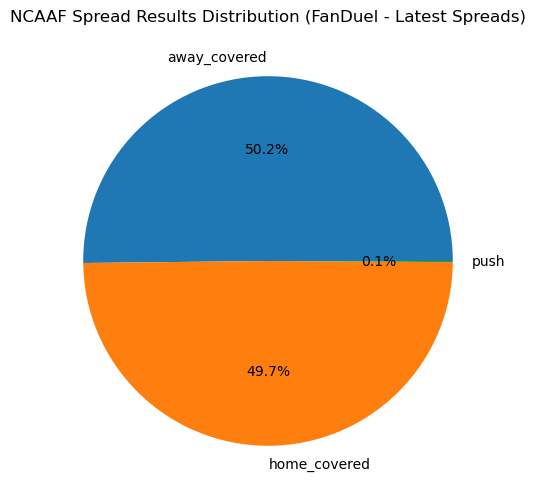

<Figure size 1400x700 with 0 Axes>

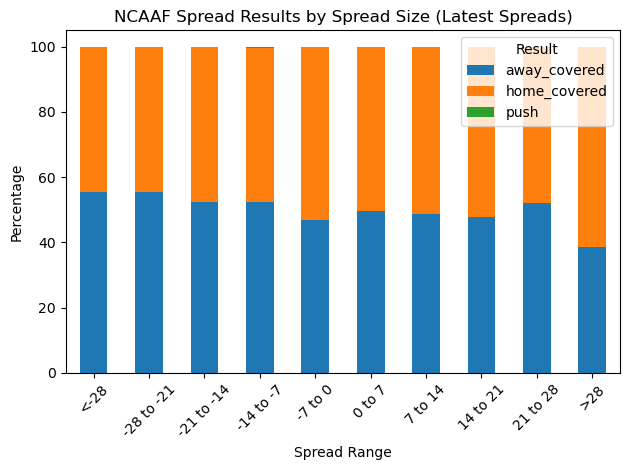


Spread Recording Timing:
Average hours before game: 54.2
Median hours before game: 40.0
Min hours before game: 16.3
Max hours before game: 2274.0


<Figure size 1200x600 with 0 Axes>

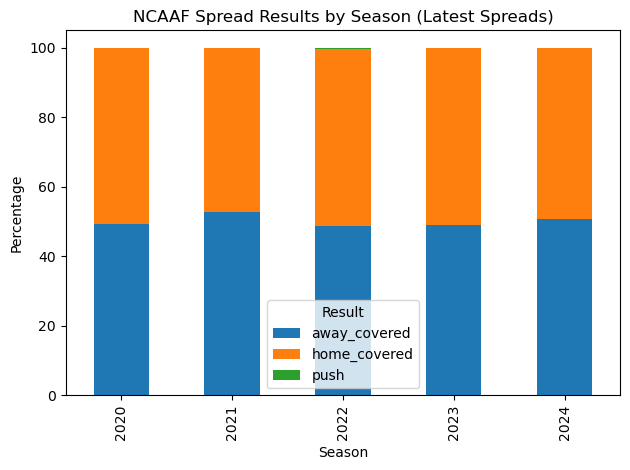


Performance When Team is Favorite:
result    away_covered  home_covered  push
favorite                                  
away             48.69         51.31  0.00
home             51.01         48.83  0.16

Spread Accuracy:
Average difference from spread: -0.21 points
Median difference from spread: -0.50 points
Standard deviation: 15.36 points


In [2]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore') 

# Connect to your database
conn = mysql.connector.connect(
    host="127.0.0.1",
    port="3307",
    user="root",
    database="odds_tracker"
)

# Query to get only the latest FanDuel spread for each game
query = """
WITH LatestSpreads AS (
    SELECT 
        s.id as spread_id,
        s.game_id,
        s.recorded_at,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at DESC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
)
SELECT 
    s.spread,
    sr.result,
    g.commence_time,
    ht.name as home_team,
    at.name as away_team,
    sc.home_score,
    sc.away_score,
    s.recorded_at as spread_recorded_at
FROM spread_results sr
JOIN spreads s ON sr.spread_id = s.id
JOIN LatestSpreads ls ON s.id = ls.spread_id
JOIN casinos c ON s.casino_id = c.id
JOIN games g ON s.game_id = g.id
JOIN teams ht ON g.home_team_id = ht.id
JOIN teams at ON g.away_team_id = at.id
JOIN scores sc ON sr.score_id = sc.id
JOIN sports sp ON g.sport_id = sp.id
WHERE c.name = 'FanDuel'
AND sp.key = 'americanfootball_ncaaf'  -- Changed from NFL to NCAAF
AND ls.rn = 1  -- Only get the latest spread
ORDER BY g.commence_time;
"""

# Load data into pandas
df = pd.read_sql(query, conn)

# Basic Calculations
total_games = len(df)
result_counts = df['result'].value_counts()
result_percentages = (result_counts / total_games * 100).round(2)

# Display overall results
print("NCAAF Spread Results for FanDuel (Latest Spreads Only)")
print("=" * 50)
print(f"\nTotal Games Analyzed: {total_games}")
print("\nResults Breakdown:")
for result, count in result_counts.items():
    percentage = result_percentages[result]
    print(f"{result}: {count} games ({percentage}%)")

# Plotting overall distribution
plt.figure(figsize=(10, 6))
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%')
plt.title('NCAAF Spread Results Distribution (FanDuel - Latest Spreads)')
plt.show()

# Analysis by spread size (adjusted bins for college football's larger spreads)
df['spread_bucket'] = pd.cut(df['spread'], 
                           bins=[-35, -28, -21, -14, -7, 0, 7, 14, 21, 28, 35],
                           labels=['<-28', '-28 to -21', '-21 to -14', '-14 to -7', 
                                 '-7 to 0', '0 to 7', '7 to 14', '14 to 21', 
                                 '21 to 28', '>28'])

spread_analysis = pd.crosstab(df['spread_bucket'], df['result'], normalize='index') * 100

plt.figure(figsize=(14, 7))  # Increased figure size for more spread buckets
spread_analysis.plot(kind='bar', stacked=True)
plt.title('NCAAF Spread Results by Spread Size (Latest Spreads)')
plt.xlabel('Spread Range')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Result')
plt.tight_layout()
plt.show()

# Time between spread recording and game
df['spread_recorded_at'] = pd.to_datetime(df['spread_recorded_at'])
df['commence_time'] = pd.to_datetime(df['commence_time'])
df['hours_before_game'] = (df['commence_time'] - df['spread_recorded_at']).dt.total_seconds() / 3600

print("\nSpread Recording Timing:")
print(f"Average hours before game: {df['hours_before_game'].mean():.1f}")
print(f"Median hours before game: {df['hours_before_game'].median():.1f}")
print(f"Min hours before game: {df['hours_before_game'].min():.1f}")
print(f"Max hours before game: {df['hours_before_game'].max():.1f}")

# Season by season analysis
df['season'] = pd.to_datetime(df['commence_time']).dt.year
season_analysis = pd.crosstab(df['season'], df['result'], normalize='index') * 100

plt.figure(figsize=(12, 6))
season_analysis.plot(kind='bar', stacked=True)
plt.title('NCAAF Spread Results by Season (Latest Spreads)')
plt.xlabel('Season')
plt.ylabel('Percentage')
plt.legend(title='Result')
plt.tight_layout()
plt.show()

# Home/Away favorite analysis
df['favorite'] = df['spread'].apply(lambda x: 'home' if x < 0 else 'away')
favorite_analysis = pd.crosstab([df['favorite']], df['result'], normalize='index') * 100

print("\nPerformance When Team is Favorite:")
print(favorite_analysis.round(2))

# Average margin vs spread
df['actual_margin'] = df['home_score'] - df['away_score']
df['spread_difference'] = df['actual_margin'] + df['spread']  # How far off the spread was

print("\nSpread Accuracy:")
print(f"Average difference from spread: {df['spread_difference'].mean():.2f} points")
print(f"Median difference from spread: {df['spread_difference'].median():.2f} points")
print(f"Standard deviation: {df['spread_difference'].std():.2f} points")

# Close connection
conn.close()


Sample of raw data:
   spread        result  home_score  away_score
0     6.5  away_covered          10          42
1    -6.5  home_covered          29          13
2    -2.5  home_covered          23          20
3    27.5  home_covered          28          51
4   -12.5  away_covered          20          18

Raw counts by spread bucket:
result         away_covered  home_covered  push
spread_bucket                                  
-35 to -28               36            29     0
-28 to -21               80            64     0
-21 to -14              120           109     0
-14 to -7               157           142     1
-7 to -3                129           163     1
-3 to 0                  89            82     0
0 to 3                   73            72     0
3 to 7                   93            96     0
7 to 14                 107           113     0
14 to 21                 51            56     0
21 to 28                 24            22     0
28 to 35                  5          

<Figure size 1500x800 with 0 Axes>

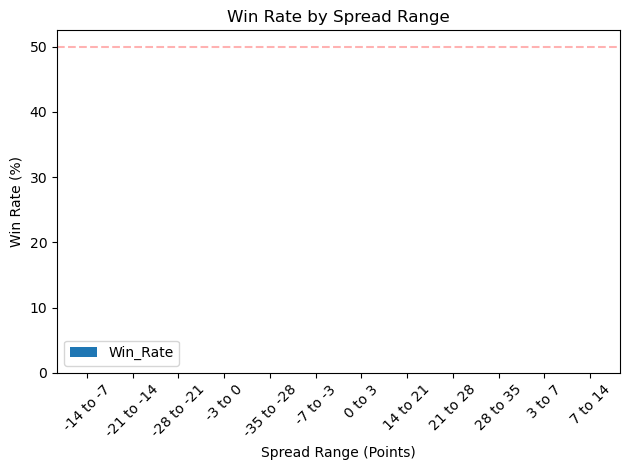


Overall Results by Spread Direction:
result                    away_covered  home_covered  push
spread_direction                                          
Negative (Home Favorite)         51.01         48.83  0.16
Positive (Home Underdog)         48.69         51.31  0.00


In [3]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Connect to your database
conn = mysql.connector.connect(
    host="127.0.0.1",
    port="3307",
    user="root",
    database="odds_tracker"
)

query = """
WITH LatestSpreads AS (
    SELECT 
        s.id as spread_id,
        s.game_id,
        s.recorded_at,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at DESC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
)
SELECT 
    s.spread,
    sr.result,
    g.commence_time,
    ht.name as home_team,
    at.name as away_team,
    sc.home_score,
    sc.away_score,
    s.recorded_at as spread_recorded_at
FROM spread_results sr
JOIN spreads s ON sr.spread_id = s.id
JOIN LatestSpreads ls ON s.id = ls.spread_id
JOIN casinos c ON s.casino_id = c.id
JOIN games g ON s.game_id = g.id
JOIN teams ht ON g.home_team_id = ht.id
JOIN teams at ON g.away_team_id = at.id
JOIN scores sc ON sr.score_id = sc.id
JOIN sports sp ON g.sport_id = sp.id
WHERE c.name = 'FanDuel'
AND sp.key = 'americanfootball_ncaaf'
AND ls.rn = 1
ORDER BY g.commence_time;
"""

# Load data into pandas
df = pd.read_sql(query, conn)

print("\nSample of raw data:")
print(df[['spread', 'result', 'home_score', 'away_score']].head())

# Create spread buckets that maintain the sign
df['spread_bucket'] = pd.cut(
    df['spread'],
    bins=[-35, -28, -21, -14, -7, -3, 0, 3, 7, 14, 21, 28, 35],
    labels=['-35 to -28', '-28 to -21', '-21 to -14', '-14 to -7', '-7 to -3', 
            '-3 to 0', '0 to 3', '3 to 7', '7 to 14', '14 to 21', '21 to 28', '28 to 35']
)

# Basic results by spread bucket
results_by_bucket = pd.crosstab(df['spread_bucket'], df['result'])
print("\nRaw counts by spread bucket:")
print(results_by_bucket)

# Calculate percentages
results_pct = pd.crosstab(df['spread_bucket'], df['result'], normalize='index') * 100
print("\nPercentages by spread bucket:")
print(results_pct.round(2))

# Calculate summary statistics
results_summary = []
for bucket in df['spread_bucket'].dropna().unique():
    bucket_data = df[df['spread_bucket'] == bucket]
    
    total = len(bucket_data)
    wins = len(bucket_data[bucket_data['result'] == 'WIN'])
    losses = len(bucket_data[bucket_data['result'] == 'LOSS'])
    pushes = len(bucket_data[bucket_data['result'] == 'PUSH'])
    
    if total > 0:
        win_rate = (wins / (wins + losses)) * 100 if (wins + losses) > 0 else 0
        roi = ((wins * 0.9091) - losses) / (wins + losses) * 100 if (wins + losses) > 0 else 0
    else:
        win_rate = 0
        roi = 0
        
    results_summary.append({
        'Spread_Range': bucket,
        'Total_Games': total,
        'Wins': wins,
        'Losses': losses,
        'Pushes': pushes,
        'Win_Rate': win_rate,
        'ROI': roi
    })

results_df = pd.DataFrame(results_summary)
results_df = results_df.sort_values('Spread_Range')  # Sort by spread range

print("\nDetailed Results by Spread Range:")
print(results_df.round(2))

# Visualize results
plt.figure(figsize=(15, 8))
ax = results_df.plot(kind='bar', x='Spread_Range', y=['Win_Rate'], width=0.8)
plt.title('Win Rate by Spread Range')
plt.xlabel('Spread Range (Points)')
plt.ylabel('Win Rate (%)')
plt.axhline(y=50, color='r', linestyle='--', alpha=0.3)  # Add 50% reference line
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate actual margin vs spread
df['actual_margin'] = df['home_score'] - df['away_score']
df['spread_difference'] = df['actual_margin'] + df['spread']

# Analyze accuracy by spread direction
df['spread_direction'] = df['spread'].apply(lambda x: 'Negative (Home Favorite)' if x < 0 else 'Positive (Home Underdog)')

print("\nOverall Results by Spread Direction:")
direction_results = pd.crosstab(df['spread_direction'], df['result'], normalize='index') * 100
print(direction_results.round(2))

# Close connection
conn.close()


NFL Analysis

Total Games: 1112

Results Breakdown:
away_covered: 572 games (51.4%)
home_covered: 519 games (46.7%)
push: 21 games (1.9%)

Margin Analysis:
Average Margin: 1.6 points
Median Margin: 2.0 points

Results by Spread Range:
result        away_covered  home_covered  push
spread_range                                  
< -14                 44.4          55.6   0.0
-14 to -7.5           49.4          48.8   1.9
-7.5 to -3            56.4          42.2   1.4
-3 to 3               51.7          46.6   1.7
3 to 7.5              45.5          51.3   3.2
7.5 to 14             40.0          57.1   2.9
> 14                  50.0          50.0   0.0

College Football Analysis

Total Games: 422

Results Breakdown:
away_covered: 214 games (50.7%)
home_covered: 208 games (49.3%)

Margin Analysis:
Average Margin: 4.5 points
Median Margin: 4.0 points

Results by Spread Range:
result        away_covered  home_covered
spread_range                            
< -14                 54.9       

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (2,).

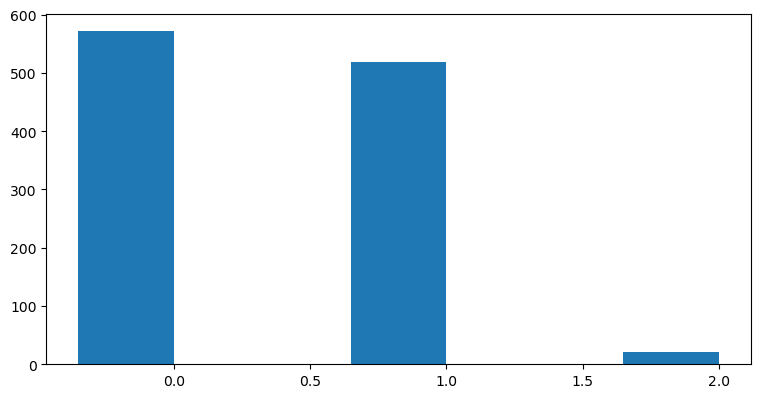

In [4]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create SQLAlchemy engine
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker')

# Query for both NFL and College Football
query = """
WITH FirstSpread AS (
    SELECT 
        s.game_id,
        s.spread as opening_spread,
        s.recorded_at as opening_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at ASC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
),
LastSpread AS (
    SELECT 
        s.id as spread_id,
        s.game_id,
        s.spread as closing_spread,
        s.recorded_at as closing_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at DESC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
)
SELECT 
    g.id as game_id,
    sp.key as sport_key,
    ht.name as home_team,
    at.name as away_team,
    fs.opening_spread,
    ls.closing_spread,
    (ls.closing_spread - fs.opening_spread) as spread_movement,
    sr.result,
    sc.home_score,
    sc.away_score,
    g.commence_time
FROM games g
JOIN FirstSpread fs ON g.id = fs.game_id AND fs.rn = 1
JOIN LastSpread ls ON g.id = ls.game_id AND ls.rn = 1
JOIN teams ht ON g.home_team_id = ht.id
JOIN teams at ON g.away_team_id = at.id
JOIN sports sp ON g.sport_id = sp.id
JOIN spread_results sr ON sr.spread_id = ls.spread_id
JOIN scores sc ON sr.score_id = sc.id
WHERE sp.key IN ('americanfootball_nfl', 'americanfootball_ncaaf')
ORDER BY g.commence_time DESC;
"""

# Load data
df = pd.read_sql(query, engine)

# Separate NFL and NCAAF data
nfl_df = df[df['sport_key'] == 'americanfootball_nfl']
ncaaf_df = df[df['sport_key'] == 'americanfootball_ncaaf']

# Function to analyze results
def analyze_results(data, title):
    total_games = len(data)
    result_counts = data['result'].value_counts()
    result_percentages = (result_counts / total_games * 100).round(1)
    
    print(f"\n{title} Analysis")
    print("=" * 50)
    print(f"\nTotal Games: {total_games}")
    
    print("\nResults Breakdown:")
    for result, count in result_counts.items():
        print(f"{result}: {count} games ({result_percentages[result]}%)")
    
    # Calculate margins
    data['margin'] = data['home_score'] - data['away_score']
    
    print(f"\nMargin Analysis:")
    print(f"Average Margin: {data['margin'].mean():.1f} points")
    print(f"Median Margin: {data['margin'].median():.1f} points")
    
    # Spread range analysis
    data['spread_range'] = pd.cut(
        data['opening_spread'],
        bins=[-float('inf'), -14, -7.5, -3, 3, 7.5, 14, float('inf')],
        labels=['< -14', '-14 to -7.5', '-7.5 to -3', '-3 to 3', '3 to 7.5', '7.5 to 14', '> 14']
    )
    
    spread_analysis = pd.crosstab(data['spread_range'], data['result'], normalize='index') * 100
    print("\nResults by Spread Range:")
    print(spread_analysis.round(1))
    
    return result_counts, spread_analysis

# Create visualization function
def plot_comparisons(nfl_results, ncaaf_results, nfl_spread_analysis, ncaaf_spread_analysis):
    plt.figure(figsize=(20, 10))
    
    # Overall Results Comparison
    plt.subplot(2, 2, 1)
    width = 0.35
    x = np.arange(len(nfl_results))
    plt.bar(x - width/2, nfl_results, width, label='NFL')
    plt.bar(x + width/2, ncaaf_results, width, label='NCAAF')
    plt.title('NFL vs NCAAF Results Distribution')
    plt.xticks(x, nfl_results.index)
    plt.ylabel('Number of Games')
    plt.legend()
    
    # Spread Range Results
    plt.subplot(2, 2, 2)
    nfl_spread_analysis['home_covered'].plot(kind='bar', position=0, width=0.4, alpha=0.8, label='NFL Home Covered')
    ncaaf_spread_analysis['home_covered'].plot(kind='bar', position=1, width=0.4, alpha=0.8, label='NCAAF Home Covered')
    plt.title('Home Cover % by Spread Range')
    plt.xticks(rotation=45)
    plt.ylabel('Percentage')
    plt.legend()
    
    # Line Movement Analysis
    plt.subplot(2, 2, 3)
    plt.hist(nfl_df['spread_movement'], bins=20, alpha=0.5, label='NFL')
    plt.hist(ncaaf_df['spread_movement'], bins=20, alpha=0.5, label='NCAAF')
    plt.title('Line Movement Distribution')
    plt.xlabel('Spread Movement')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Margin Distribution
    plt.subplot(2, 2, 4)
    plt.hist(nfl_df['home_score'] - nfl_df['away_score'], bins=20, alpha=0.5, label='NFL')
    plt.hist(ncaaf_df['home_score'] - ncaaf_df['away_score'], bins=20, alpha=0.5, label='NCAAF')
    plt.title('Margin Distribution')
    plt.xlabel('Home Team Margin')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Run analysis
nfl_results, nfl_spread_analysis = analyze_results(nfl_df, "NFL")
ncaaf_results, ncaaf_spread_analysis = analyze_results(ncaaf_df, "College Football")

# Create visualizations
plot_comparisons(nfl_results, ncaaf_results, nfl_spread_analysis, ncaaf_spread_analysis)

# Additional Analysis: Home/Away Performance by Conference (NCAAF only)
# Note: You'd need to add conference information to your teams table for this

# Season Trends
plt.figure(figsize=(15, 6))
for sport_df, label in [(nfl_df, 'NFL'), (ncaaf_df, 'NCAAF')]:
    sport_df['season'] = pd.to_datetime(sport_df['commence_time']).dt.year
    season_results = sport_df.groupby('season')['result'].value_counts(normalize=True)
    season_results = season_results.unstack()
    season_results['home_covered'].plot(label=f'{label} Home Cover %', marker='o')

plt.title('Home Cover % by Season')
plt.xlabel('Season')
plt.ylabel('Home Cover %')
plt.legend()
plt.grid(True)
plt.show()


NFL Home Underdog Analysis

Total Home Underdog Games: 8369

Overall Results:
away_covered: 4200 games (50.2%)
home_covered: 4070 games (48.6%)
push: 99 games (1.2%)

Results by Spread Range:
result        away_covered  home_covered  push
spread_range                                  
0-3                   55.6          42.4   1.9
3-7                   46.0          53.5   0.5
7-10                  41.5          58.5   0.0
10-14                 42.9          55.3   1.8
14+                   41.7          58.3   0.0

Outright Win Percentage: 34.1%

College Football Home Underdog Analysis

Total Home Underdog Games: 7842

Overall Results:
home_covered: 4183 games (53.3%)
away_covered: 3646 games (46.5%)
push: 13 games (0.2%)

Results by Spread Range:
result        away_covered  home_covered  push
spread_range                                  
0-3                   51.2          48.4   0.4
3-7                   49.5          50.4   0.0
7-10                  39.4          60.5   0.1
10-14

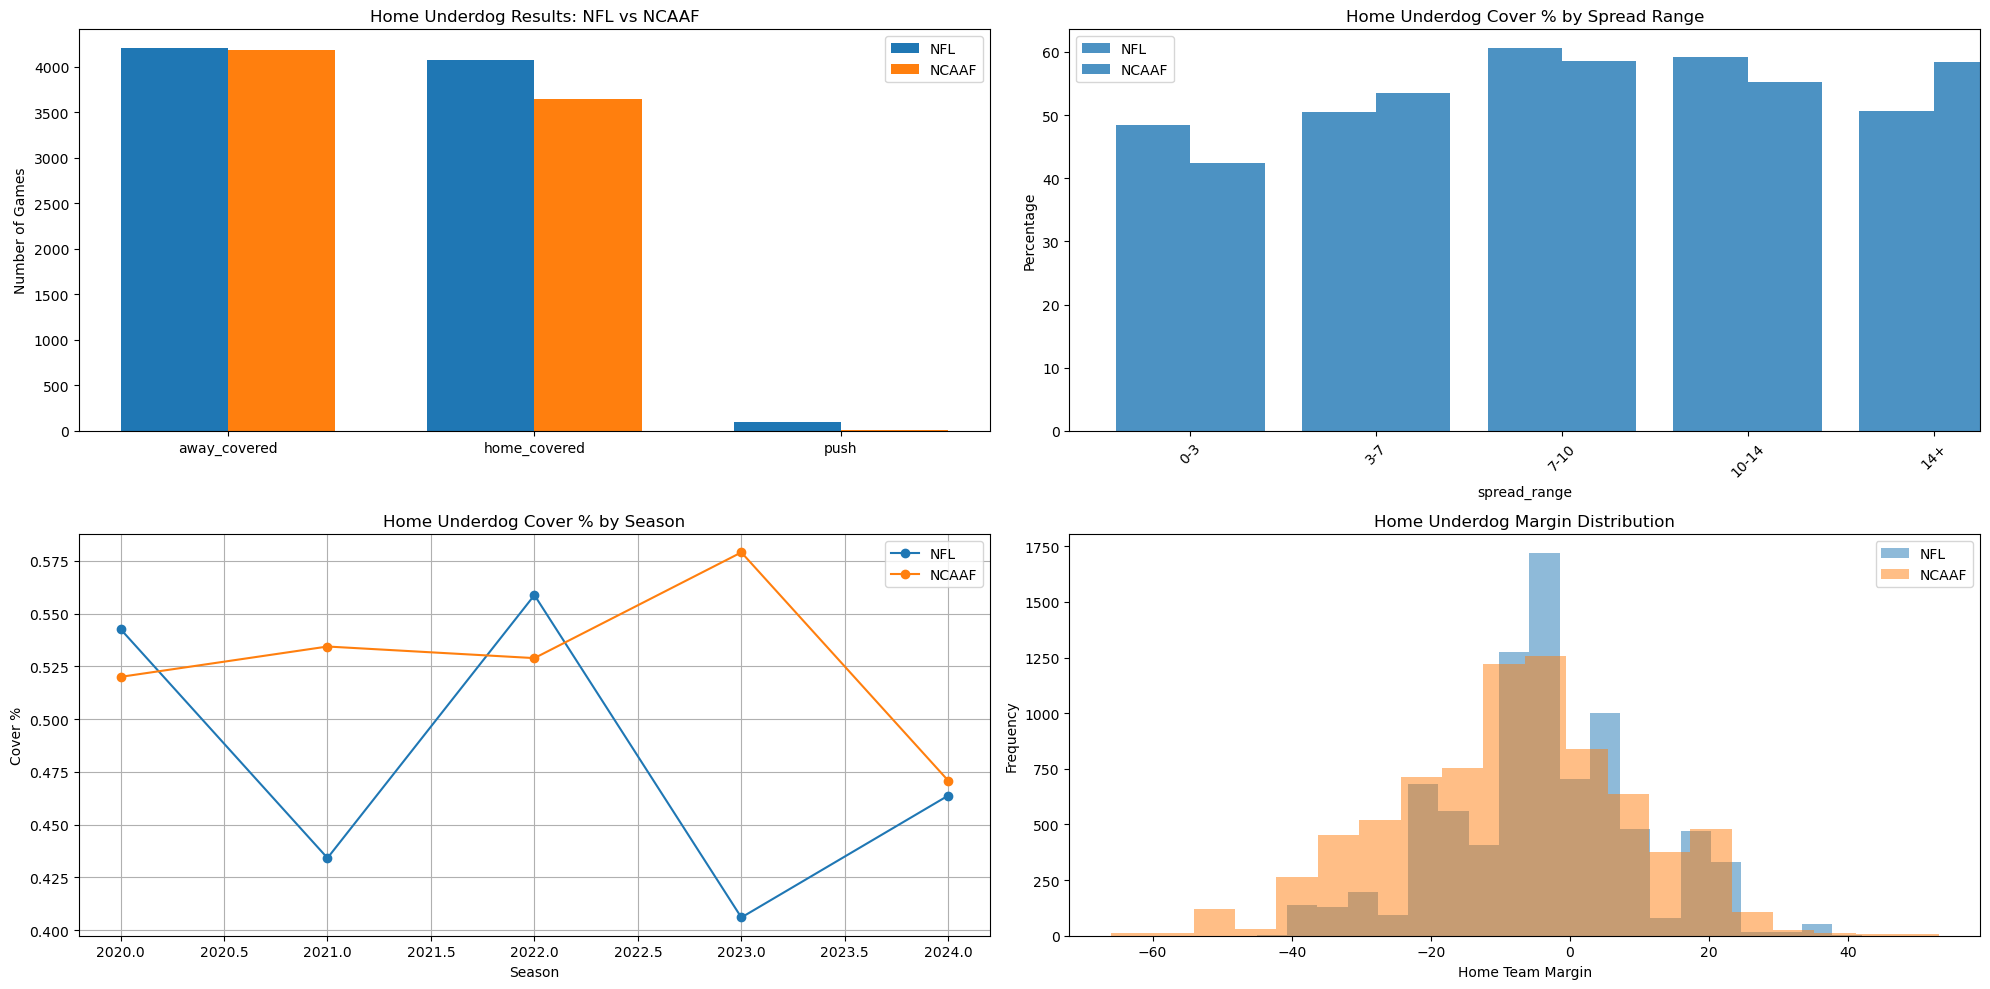


Money Line Analysis (Outright Wins)

NFL Outright Wins by Spread Range:
spread_range
0-3      39.8
3-7      31.3
7-10     14.5
10-14    24.7
14+      25.0
Name: mean, dtype: float64

NCAAF Outright Wins by Spread Range:
spread_range
0-3      47.1
3-7      35.0
7-10     29.6
10-14    36.5
14+       7.3
Name: mean, dtype: float64


In [4]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create SQLAlchemy engine
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker?charset=utf8mb4')

# Query focusing on home underdogs
query = """
    SELECT 
        g.id as game_id,
        sp.key as sport_key,
        s.spread as opening_spread,
        sr.result,
        sc.home_score,
        sc.away_score,
        g.commence_time
    FROM games g
    JOIN spreads s ON g.id = s.game_id
    JOIN sports sp ON g.sport_id = sp.id
    JOIN spread_results sr ON sr.spread_id = s.id
    JOIN scores sc ON sr.score_id = sc.id
    JOIN casinos c ON s.casino_id = c.id
    WHERE sp.key IN ('americanfootball_nfl', 'americanfootball_ncaaf')
    AND s.spread > 0  -- Home team is underdog
    AND c.name = 'FanDuel'
    ORDER BY g.commence_time DESC;
    """

# Load data
df = pd.read_sql(query, engine)

# Separate by sport
nfl_df = df[df['sport_key'] == 'americanfootball_nfl']
ncaaf_df = df[df['sport_key'] == 'americanfootball_ncaaf']

def analyze_home_dogs(data, sport_name):
    print(f"\n{sport_name} Home Underdog Analysis")
    print("=" * 50)
    
    # Overall results
    total_games = len(data)
    result_counts = data['result'].value_counts()
    result_percentages = (result_counts / total_games * 100).round(1)
    
    print(f"\nTotal Home Underdog Games: {total_games}")
    print("\nOverall Results:")
    for result, count in result_counts.items():
        print(f"{result}: {count} games ({result_percentages[result]}%)")
    
    # Group by spread ranges
    data['spread_range'] = pd.cut(
        data['opening_spread'],
        bins=[0, 3, 7, 10, 14, float('inf')],
        labels=['0-3', '3-7', '7-10', '10-14', '14+']
    )
    
    spread_analysis = pd.crosstab(
        data['spread_range'], 
        data['result'], 
        normalize='index'
    ) * 100
    
    print("\nResults by Spread Range:")
    print(spread_analysis.round(1))
    
    # Calculate straight up wins
    data['outright_win'] = (data['home_score'] > data['away_score'])
    outright_wins = data['outright_win'].mean() * 100
    
    print(f"\nOutright Win Percentage: {outright_wins:.1f}%")
    
    return result_counts, spread_analysis, data

# Analyze both sports
nfl_results, nfl_spread_analysis, nfl_processed = analyze_home_dogs(nfl_df, "NFL")
ncaaf_results, ncaaf_spread_analysis, ncaaf_processed = analyze_home_dogs(ncaaf_df, "College Football")

# Visualizations
plt.figure(figsize=(20, 10))

# Overall Results Comparison
plt.subplot(2, 2, 1)
width = 0.35
x = np.arange(len(nfl_results))
plt.bar(x - width/2, nfl_results, width, label='NFL')
plt.bar(x + width/2, ncaaf_results, width, label='NCAAF')
plt.title('Home Underdog Results: NFL vs NCAAF')
plt.xticks(x, nfl_results.index)
plt.ylabel('Number of Games')
plt.legend()

# Results by Spread Range
plt.subplot(2, 2, 2)
if 'home_covered' in nfl_spread_analysis.columns:
    nfl_spread_analysis['home_covered'].plot(kind='bar', position=0, width=0.4, alpha=0.8, label='NFL')
if 'home_covered' in ncaaf_spread_analysis.columns:
    ncaaf_spread_analysis['home_covered'].plot(kind='bar', position=1, width=0.4, alpha=0.8, label='NCAAF')
plt.title('Home Underdog Cover % by Spread Range')
plt.xticks(rotation=45)
plt.ylabel('Percentage')
plt.legend()

# Season Analysis
plt.subplot(2, 2, 3)
for df, label in [(nfl_processed, 'NFL'), (ncaaf_processed, 'NCAAF')]:
    df['season'] = pd.to_datetime(df['commence_time']).dt.year
    season_results = df.groupby('season')['result'].value_counts(normalize=True)
    if 'home_covered' in season_results.unstack().columns:
        season_results.unstack()['home_covered'].plot(label=f'{label}', marker='o')
plt.title('Home Underdog Cover % by Season')
plt.xlabel('Season')
plt.ylabel('Cover %')
plt.grid(True)
plt.legend()

# Margin Distribution
plt.subplot(2, 2, 4)
plt.hist(nfl_processed['home_score'] - nfl_processed['away_score'], 
         bins=20, alpha=0.5, label='NFL')
plt.hist(ncaaf_processed['home_score'] - ncaaf_processed['away_score'], 
         bins=20, alpha=0.5, label='NCAAF')
plt.title('Home Underdog Margin Distribution')
plt.xlabel('Home Team Margin')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Additional Money Line Analysis
print("\nMoney Line Analysis (Outright Wins)")
for df, sport in [(nfl_processed, 'NFL'), (ncaaf_processed, 'NCAAF')]:
    spread_win_analysis = df.groupby('spread_range')['outright_win'].agg(['count', 'mean'])
    print(f"\n{sport} Outright Wins by Spread Range:")
    print((spread_win_analysis['mean'] * 100).round(1))

In [5]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

# Create SQLAlchemy engine
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker?charset=utf8mb4')

query = """
WITH FirstSpread AS (
    SELECT 
        s.game_id,
        s.spread as opening_spread,
        s.recorded_at as opening_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at ASC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
),
LastSpread AS (
    SELECT 
        s.id as spread_id,
        s.game_id,
        s.spread as closing_spread,
        s.recorded_at as closing_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at DESC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
)
SELECT 
    g.id as game_id,
    ht.name as home_team,
    at.name as away_team,
    fs.opening_spread,
    ls.closing_spread,
    sr.result,
    sc.home_score,
    sc.away_score
FROM games g
JOIN FirstSpread fs ON g.id = fs.game_id AND fs.rn = 1
JOIN LastSpread ls ON g.id = ls.game_id AND ls.rn = 1
JOIN teams ht ON g.home_team_id = ht.id
JOIN teams at ON g.away_team_id = at.id
JOIN sports sp ON g.sport_id = sp.id
JOIN spread_results sr ON sr.spread_id = ls.spread_id
JOIN scores sc ON sr.score_id = sc.id
WHERE sp.key = 'americanfootball_ncaaf';
"""

df = pd.read_sql(query, engine)

# Calculate line movement and filter for games where line moved to favor home team more
df['spread_movement'] = df['closing_spread'] - df['opening_spread']
df['moved_to_favor_home'] = df['spread_movement'] < 0  # Negative movement means line moved to favor home team more

# Filter for games where line moved to favor home team more
home_favored_more_df = df[df['moved_to_favor_home']]

# Group by movement size
home_favored_more_df['movement_size'] = abs(home_favored_more_df['spread_movement'])
home_favored_more_df['movement_bucket'] = pd.cut(
    home_favored_more_df['movement_size'],
    bins=[0, 1, 2, 3, 4, float('inf')],
    labels=['0-1', '1-2', '2-3', '3-4', '4+']
)

# Analyze results
results = []
for bucket in home_favored_more_df['movement_bucket'].unique():
    bucket_games = home_favored_more_df[home_favored_more_df['movement_bucket'] == bucket]
    total_games = len(bucket_games)
    home_covers = (bucket_games['result'] == 'home_covered').sum()
    away_covers = (bucket_games['result'] == 'away_covered').sum()
    pushes = total_games - home_covers - away_covers
    
    results.append({
        'movement': bucket,
        'games': total_games,
        'home_cover_pct': (home_covers / total_games * 100).round(1),
        'away_cover_pct': (away_covers / total_games * 100).round(1),
        'push_pct': (pushes / total_games * 100).round(1)
    })

print("Analysis of Games Where Line Moved to Favor Home Team More")
print("=" * 70)
print(f"\nTotal Games: {len(home_favored_more_df)}")
print("\nResults by Movement Size:")
print(pd.DataFrame(results).to_string(index=False))

# Show examples of big movements
print("\nLargest Home-Favoring Movements:")
big_movements = home_favored_more_df.nlargest(10, 'movement_size')[
    ['home_team', 'away_team', 'opening_spread', 'closing_spread', 
     'spread_movement', 'result', 'home_score', 'away_score']
]
print(big_movements.to_string())

engine.dispose()

Analysis of Games Where Line Moved to Favor Home Team More

Total Games: 655

Results by Movement Size:
movement  games  home_cover_pct  away_cover_pct  push_pct
     0-1    265            53.6            46.4       0.0
     1-2    119            49.6            50.4       0.0
      4+    160            43.8            56.2       0.0
     2-3     70            54.3            45.7       0.0
     3-4     41            53.7            46.3       0.0

Largest Home-Favoring Movements:
                          home_team                       away_team  opening_spread  closing_spread  spread_movement        result  home_score  away_score
291     Southern University Jaguars          Grambling State Tigers             7.5           -42.5            -50.0  away_covered          29          26
1536                    UCF Knights          Oklahoma State Cowboys             2.5           -42.5            -45.0  away_covered          45           3
1819                   SMU Mustangs              

In [6]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

# Create SQLAlchemy engine
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker?charset=utf8mb4')

query = """
WITH FirstSpread AS (
    SELECT 
        s.game_id,
        s.spread as opening_spread,
        s.recorded_at as opening_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at ASC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
),
LastSpread AS (
    SELECT 
        s.id as spread_id,
        s.game_id,
        s.spread as closing_spread,
        s.recorded_at as closing_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at DESC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
)
SELECT 
    g.id as game_id,
    ht.name as home_team,
    at.name as away_team,
    fs.opening_spread,
    ls.closing_spread,
    sr.result,
    sc.home_score,
    sc.away_score
FROM games g
JOIN FirstSpread fs ON g.id = fs.game_id AND fs.rn = 1
JOIN LastSpread ls ON g.id = ls.game_id AND ls.rn = 1
JOIN teams ht ON g.home_team_id = ht.id
JOIN teams at ON g.away_team_id = at.id
JOIN sports sp ON g.sport_id = sp.id
JOIN spread_results sr ON sr.spread_id = ls.spread_id
JOIN scores sc ON sr.score_id = sc.id
WHERE sp.key = 'americanfootball_ncaaf';
"""

df = pd.read_sql(query, engine)

# Calculate line movement and filter for games where line moved to favor away team more
df['spread_movement'] = df['closing_spread'] - df['opening_spread']
df['moved_to_favor_away'] = df['spread_movement'] > 0  # Positive movement means line moved to favor away team more

# Filter for games where line moved to favor away team more
away_favored_more_df = df[df['moved_to_favor_away']]

# Group by movement size
away_favored_more_df['movement_size'] = abs(away_favored_more_df['spread_movement'])
away_favored_more_df['movement_bucket'] = pd.cut(
    away_favored_more_df['movement_size'],
    bins=[0, 1, 2, 3, 4, float('inf')],
    labels=['0-1', '1-2', '2-3', '3-4', '4+']
)

# Analyze results
results = []
for bucket in away_favored_more_df['movement_bucket'].unique():
    bucket_games = away_favored_more_df[away_favored_more_df['movement_bucket'] == bucket]
    total_games = len(bucket_games)
    home_covers = (bucket_games['result'] == 'home_covered').sum()
    away_covers = (bucket_games['result'] == 'away_covered').sum()
    pushes = total_games - home_covers - away_covers
    
    results.append({
        'movement': bucket,
        'games': total_games,
        'home_cover_pct': (home_covers / total_games * 100).round(1),
        'away_cover_pct': (away_covers / total_games * 100).round(1),
        'push_pct': (pushes / total_games * 100).round(1)
    })

print("Analysis of Games Where Line Moved to Favor Away Team More")
print("=" * 70)
print(f"\nTotal Games: {len(away_favored_more_df)}")
print("\nResults by Movement Size:")
print(pd.DataFrame(results).sort_values('movement', ascending=True).to_string(index=False))

# Show examples of big movements
print("\nLargest Away-Favoring Movements:")
big_movements = away_favored_more_df.nlargest(10, 'movement_size')[
    ['home_team', 'away_team', 'opening_spread', 'closing_spread', 
     'spread_movement', 'result', 'home_score', 'away_score']
]
print(big_movements.to_string())

engine.dispose()

Analysis of Games Where Line Moved to Favor Away Team More

Total Games: 743

Results by Movement Size:
movement  games  home_cover_pct  away_cover_pct  push_pct
     0-1    326            46.3            53.7       0.0
     1-2    139            46.8            52.5       0.7
     2-3     66            45.5            54.5       0.0
     3-4     53            45.3            54.7       0.0
      4+    159            52.2            47.8       0.0

Largest Away-Favoring Movements:
                          home_team                away_team  opening_spread  closing_spread  spread_movement        result  home_score  away_score
140        Penn State Nittany Lions       Maryland Terrapins           -23.5            18.5             42.0  home_covered          19          35
1658        Florida State Seminoles           Clemson Tigers            -3.5            33.5             37.0  home_covered          13          29
1830                    UCF Knights       Colorado Buffaloes          

Half-Point Spreads Analysis (-3.5 to -7.5)

Total Games: 337

Overall Results:
home_covered: 187 games (55.5%)
away_covered: 149 games (44.2%)
push: 1 games (0.3%)

Breakdown by Spread:

Spread -7.5 (55 games):
home_covered: 32 games (58.2%)
away_covered: 23 games (41.8%)

Spread -6.5 (85 games):
home_covered: 47 games (55.3%)
away_covered: 38 games (44.7%)

Spread -5.5 (51 games):
home_covered: 31 games (60.8%)
away_covered: 20 games (39.2%)

Spread -4.5 (55 games):
home_covered: 30 games (54.5%)
away_covered: 24 games (43.6%)
push: 1 games (1.8%)

Spread -3.5 (91 games):
home_covered: 47 games (51.6%)
away_covered: 44 games (48.4%)


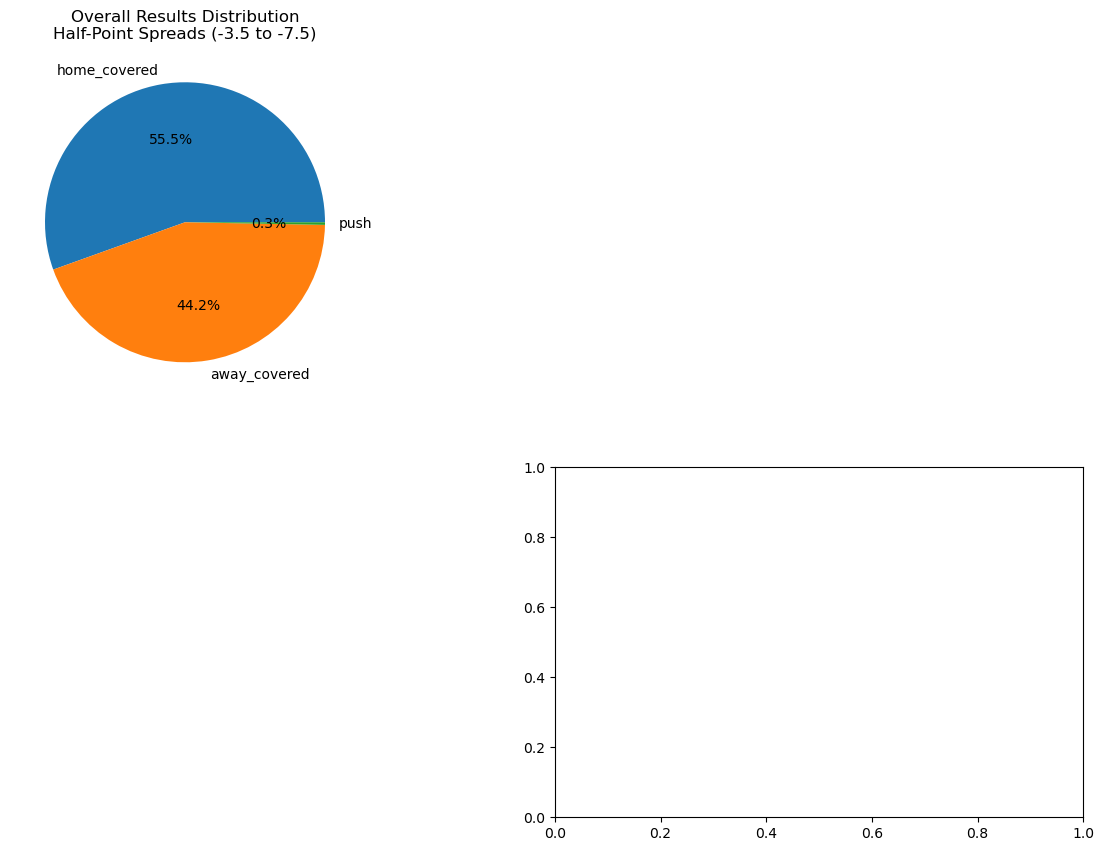

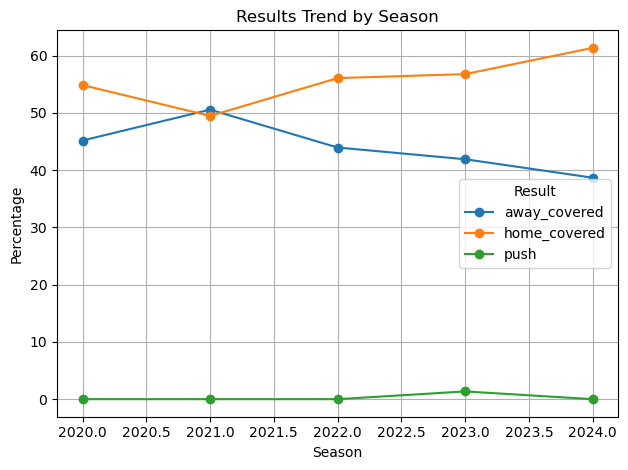


Margin Analysis:
Average Margin: 7.5 points
Median Margin: 7.0 points
Standard Deviation: 15.7 points

Season by Season Analysis:
result  away_covered  home_covered  push
season                                  
2020            45.2          54.8   0.0
2021            50.5          49.5   0.0
2022            43.9          56.1   0.0
2023            41.9          56.8   1.4
2024            38.7          61.3   0.0

Margin Analysis by Spread:
                count   mean    std  median
opening_spread                             
-7.5               55  11.95  16.34    10.0
-6.5               85   8.69  14.66     8.0
-5.5               51   7.08  14.87     7.0
-4.5               55   7.00  18.12     4.0
-3.5               91   4.15  14.52     6.0


In [7]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create SQLAlchemy engine
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker')

query = """
WITH FirstSpread AS (
    SELECT 
        s.game_id,
        s.spread as opening_spread,
        s.recorded_at as opening_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at ASC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
),
LastSpread AS (
    SELECT 
        s.id as spread_id,
        s.game_id,
        s.recorded_at as closing_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at DESC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
)
SELECT 
    g.id as game_id,
    ht.name as home_team,
    at.name as away_team,
    fs.opening_spread,
    sc.home_score,
    sc.away_score,
    sr.result,
    g.commence_time
FROM games g
JOIN FirstSpread fs ON g.id = fs.game_id AND fs.rn = 1
JOIN LastSpread ls ON g.id = ls.game_id AND ls.rn = 1
JOIN teams ht ON g.home_team_id = ht.id
JOIN teams at ON g.away_team_id = at.id
JOIN sports sp ON g.sport_id = sp.id
JOIN spread_results sr ON sr.spread_id = ls.spread_id
JOIN scores sc ON sr.score_id = sc.id
WHERE sp.key = 'americanfootball_ncaaf'
AND fs.opening_spread IN (-7.5, -6.5, -5.5, -4.5, -3.5)  -- Half-point spreads between -3.5 and -7.5
ORDER BY g.commence_time DESC;
"""

# Load data
df = pd.read_sql(query, engine)

print("Half-Point Spreads Analysis (-3.5 to -7.5)")
print("=" * 60)
print(f"\nTotal Games: {len(df)}")

# Overall Results
result_counts = df['result'].value_counts()
result_percentages = (result_counts / len(df) * 100).round(1)

print("\nOverall Results:")
for result, count in result_counts.items():
    percentage = result_percentages[result]
    print(f"{result}: {count} games ({percentage}%)")

# Breakdown by specific spread
print("\nBreakdown by Spread:")
for spread in sorted(df['opening_spread'].unique()):
    subset = df[df['opening_spread'] == spread]
    total = len(subset)
    print(f"\nSpread {spread} ({total} games):")
    for result in subset['result'].value_counts().index:
        count = len(subset[subset['result'] == result])
        percentage = np.round((count/total * 100), 1)
        print(f"{result}: {count} games ({percentage}%)")

# Calculate margins
df['margin'] = df['home_score'] - df['away_score']
df['season'] = pd.to_datetime(df['commence_time']).dt.year

# Visualization
plt.figure(figsize=(15, 10))

# Overall Results Pie Chart
plt.subplot(2, 2, 1)
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%')
plt.title('Overall Results Distribution\nHalf-Point Spreads (-3.5 to -7.5)')

# Season Trends
season_results = pd.crosstab(df['season'], df['result'], normalize='index') * 100
plt.subplot(2, 2, 4)
season_results.plot(kind='line', marker='o')
plt.title('Results Trend by Season')
plt.xlabel('Season')
plt.ylabel('Percentage')
plt.legend(title='Result')
plt.grid(True)

plt.tight_layout()
plt.show()

# Additional Analysis
print("\nMargin Analysis:")
print(f"Average Margin: {np.round(df['margin'].mean(), 1)} points")
print(f"Median Margin: {np.round(df['margin'].median(), 1)} points")
print(f"Standard Deviation: {np.round(df['margin'].std(), 1)} points")

# Season breakdown
print("\nSeason by Season Analysis:")
season_analysis = pd.crosstab(df['season'], df['result'], normalize='index') * 100
print(np.round(season_analysis, 1))

# Margin analysis by spread
print("\nMargin Analysis by Spread:")
margin_analysis = df.groupby('opening_spread')['margin'].agg([
    'count',
    'mean',
    'std',
    'median'
]).round(2)
print(margin_analysis)

# ROI Analysis (assuming -110 odds as standard)
df['roi'] = np.where(df['result'] == 'home_covered', 
                     100/110 * 100,
                     np.where(df['result'] == 'away_covered', -100, 0))

# Clean up
engine.dispose()

In [18]:
import pandas as pd
from sqlalchemy import create_engine

# Create SQLAlchemy engine
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker?charset=utf8mb4')

# Query to find games missing scores
query = """
SELECT 
    g.id as game_id,
    ht.name as home_team,
    at.name as away_team,
    g.commence_time
FROM games g
LEFT JOIN scores sc ON g.id = sc.game_id
JOIN teams ht ON g.home_team_id = ht.id
JOIN teams at ON g.away_team_id = at.id
JOIN sports sp ON g.sport_id = sp.id
WHERE sp.key = 'americanfootball_ncaaf'
    AND sc.id IS NULL
ORDER BY g.commence_time DESC;
"""

# Execute query
missing_scores_df = pd.read_sql(query, engine)

# Print results with summary
print(f"\nTotal Games Missing Scores: {len(missing_scores_df)}")
print("\nMost Recent Games Missing Scores:")
print(missing_scores_df.to_string())

# Close connection
engine.dispose()


Total Games Missing Scores: 361

Most Recent Games Missing Scores:
     game_id                           home_team                           away_team       commence_time
0       5671                  Army Black Knights                     Navy Midshipmen 2024-12-14 20:00:00
1       6095                    Miami Hurricanes                      Clemson Tigers 2024-12-08 01:00:00
2       5670                    Texas A&M Aggies                     Texas Longhorns 2024-11-30 20:30:00
3       5668                         USC Trojans           Notre Dame Fighting Irish 2024-11-30 18:00:00
4       5587                 Ohio State Buckeyes                 Michigan Wolverines 2024-11-30 17:00:00
5       5591            North Carolina Tar Heels                   NC State Wolfpack 2024-11-30 17:00:00
6       5592           Wake Forest Demon Deacons                    Duke Blue Devils 2024-11-30 17:00:00
7       5702                      Clemson Tigers            South Carolina Gamecocks 2024-11

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

# Create SQLAlchemy engine
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker?charset=utf8mb4')

query = """
    SELECT 
        g.id as game_id,
        g.commence_time,
        ht.name as home_team,
        at.name as away_team,
        s.spread as opening_spread,
        sr.result,
        sc.home_score,
        sc.away_score,
        YEAR(g.commence_time) as season
    FROM games g
    JOIN spreads s ON g.id = s.game_id
    JOIN sports sp ON g.sport_id = sp.id
    JOIN spread_results sr ON sr.spread_id = s.id
    JOIN scores sc ON sr.score_id = sc.id
    JOIN casinos c ON s.casino_id = c.id
    JOIN teams ht ON g.home_team_id = ht.id
    JOIN teams at ON g.away_team_id = at.id
    WHERE sp.key = 'americanfootball_ncaaf'
    AND s.spread BETWEEN -8 AND 8
    AND c.name = 'FanDuel'
    ORDER BY g.commence_time DESC;
"""

df = pd.read_sql(query, engine)

# Create half-point spread ranges with clearer labels
bins = [-8.1, -7.75, -7.25, -6.75, -6.25, -5.75, -5.25, -4.75, -4.25, -3.75, -3.25, 
        -2.75, -2.25, -1.75, -1.25, -0.75, -0.25, 0.25, 0.75, 1.25, 1.75, 2.25, 
        2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75, 6.25, 6.75, 7.25, 7.75, 8.1]

labels = ['Home -8', 'Home -7.5', 'Home -7', 'Home -6.5', 'Home -6', 'Home -5.5', 
          'Home -5', 'Home -4.5', 'Home -4', 'Home -3.5', 'Home -3', 'Home -2.5',
          'Home -2', 'Home -1.5', 'Home -1', 'Home -0.5', 'PK', 'Home +0.5', 
          'Home +1', 'Home +1.5', 'Home +2', 'Home +2.5', 'Home +3', 'Home +3.5',
          'Home +4', 'Home +4.5', 'Home +5', 'Home +5.5', 'Home +6', 'Home +6.5',
          'Home +7', 'Home +7.5', 'Home +8']

df['spread_bucket'] = pd.cut(
    df['opening_spread'],
    bins=bins,
    labels=labels
)

df['margin'] = df['home_score'] - df['away_score']
df['home_won'] = df['margin'] > 0

print("\nNCAAF Spread Analysis (-8 to +8)")
print("=" * 80)
print("\nResults by Spread (minimum 10 games):")
print("-" * 80)

# Print detailed result distribution for each spread
for spread in sorted(df['spread_bucket'].unique()):
    spread_data = df[df['spread_bucket'] == spread]
    total_games = len(spread_data)
    
    if total_games >= 10:  # Only show spreads with at least 10 games
        result_counts = spread_data['result'].value_counts()
        
        home_covered = result_counts.get('home_covered', 0)
        away_covered = result_counts.get('away_covered', 0)
        push = result_counts.get('push', 0)
        
        home_cover_pct = (home_covered / total_games * 100)
        away_cover_pct = (away_covered / total_games * 100)
        push_pct = (push / total_games * 100)
        
        print(f"\n{spread}")
        print(f"Total Games: {total_games}")
        print(f"Home Covered: {home_covered} ({home_cover_pct:.1f}%)")
        print(f"Away Covered: {away_covered} ({away_cover_pct:.1f}%)")
        print(f"Push: {push} ({push_pct:.1f}%)")
        print(f"Average Margin: {spread_data['margin'].mean():.1f}")
        print(f"ROI: {((home_cover_pct / 100 * 100) - ((1 - home_cover_pct / 100) * 110)) / 1.1:.1f}%")
        print("-" * 40)

print("\nProfitable Spreads (minimum 10 games):")
print("-" * 80)
for spread in sorted(df['spread_bucket'].unique()):
    spread_data = df[df['spread_bucket'] == spread]
    total_games = len(spread_data)
    
    if total_games >= 10:
        home_covered = (spread_data['result'] == 'home_covered').sum()
        home_cover_pct = (home_covered / total_games * 100)
        roi = ((home_cover_pct / 100 * 100) - ((1 - home_cover_pct / 100) * 110)) / 1.1
        
        if roi > 0:
            print(f"{spread:8}: ROI {roi:.1f}% ({total_games} games, {home_cover_pct:.1f}% cover rate)")

# Additional summary statistics
print("\nSummary Statistics:")
print("-" * 80)
profitable_spreads = df.groupby('spread_bucket').agg({
    'game_id': 'count',
    'result': lambda x: (x == 'home_covered').mean() * 100
}).reset_index()

profitable_spreads['roi'] = ((profitable_spreads['result'] / 100 * 100) - 
                           ((1 - profitable_spreads['result'] / 100) * 110)) / 1.1

profitable_spreads = profitable_spreads[profitable_spreads['game_id'] >= 10]
profitable_spreads = profitable_spreads[profitable_spreads['roi'] > 0]

print(f"\nTotal Profitable Spreads: {len(profitable_spreads)}")
print(f"Average ROI of Profitable Spreads: {profitable_spreads['roi'].mean():.1f}%")
print(f"Best ROI: {profitable_spreads['roi'].max():.1f}% ({profitable_spreads.loc[profitable_spreads['roi'].idxmax(), 'spread_bucket']})")
print(f"Total Games in Profitable Spreads: {profitable_spreads['game_id'].sum():,}")


NCAAF Spread Analysis (-8 to +8)

Results by Spread (minimum 10 games):
--------------------------------------------------------------------------------

Home +0.5
Total Games: 17
Home Covered: 14 (82.4%)
Away Covered: 3 (17.6%)
Push: 0 (0.0%)
Average Margin: 10.5
ROI: 57.2%
----------------------------------------

Home +1
Total Games: 111
Home Covered: 94 (84.7%)
Away Covered: 17 (15.3%)
Push: 0 (0.0%)
Average Margin: 3.8
ROI: 61.7%
----------------------------------------

Home +1.5
Total Games: 567
Home Covered: 275 (48.5%)
Away Covered: 292 (51.5%)
Push: 0 (0.0%)
Average Margin: -0.4
ROI: -7.4%
----------------------------------------

Home +2.5
Total Games: 775
Home Covered: 305 (39.4%)
Away Covered: 470 (60.6%)
Push: 0 (0.0%)
Average Margin: -4.5
ROI: -24.9%
----------------------------------------

Home +3
Total Games: 109
Home Covered: 75 (68.8%)
Away Covered: 28 (25.7%)
Push: 6 (5.5%)
Average Margin: 2.0
ROI: 31.4%
----------------------------------------

Home +3.5
Total Ga

In [16]:
from sqlalchemy import create_engine
import pandas as pd

# Create SQLAlchemy engine
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker')

query = """
WITH FirstSpread AS (
    SELECT 
        s.game_id,
        s.spread as opening_spread,
        s.recorded_at as opening_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at ASC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
),
LastSpread AS (
    SELECT 
        s.id as spread_id,
        s.game_id,
        s.spread as closing_spread,
        s.recorded_at as closing_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at DESC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
)
SELECT 
    g.id as game_id,
    ht.name as home_team,
    at.name as away_team,
    fs.opening_spread,
    ls.closing_spread,
    (ls.closing_spread - fs.opening_spread) as spread_movement,
    sr.result
FROM games g
JOIN FirstSpread fs ON g.id = fs.game_id AND fs.rn = 1
JOIN LastSpread ls ON g.id = ls.game_id AND ls.rn = 1
JOIN teams ht ON g.home_team_id = ht.id
JOIN teams at ON g.away_team_id = at.id
JOIN sports sp ON g.sport_id = sp.id
JOIN spread_results sr ON sr.spread_id = ls.spread_id
WHERE sp.key = 'americanfootball_ncaaf'
AND fs.opening_spread < 0  -- Home team is favorite (negative spread)
AND ls.closing_spread < fs.opening_spread  -- Line moves more negative
AND (ls.closing_spread - fs.opening_spread) BETWEEN -4 AND -2  -- Movement between 2-4 points
"""

# Load data
df = pd.read_sql(query, engine)

# Calculate cover percentage
total_games = len(df)
home_covers = len(df[df['result'] == 'home_covered'])
away_covers = len(df[df['result'] == 'away_covered'])
pushes = len(df[df['result'] == 'wash'])

# Remove pushes from the total for percentage calculation
games_without_pushes = total_games - pushes
home_cover_percentage = round((home_covers / games_without_pushes * 100), 2)
away_cover_percentage = round((away_covers / games_without_pushes * 100), 2)

print("\nAnalysis of Home Favorites When Line Moves 2-4 Points More Negative:")
print("=" * 70)
print(f"Total Games: {total_games}")
print(f"Home Team (Favorite) Covers: {home_covers}")
print(f"Away Team (Underdog) Covers: {away_covers}")
print(f"Pushes: {pushes}")
print(f"Home Favorite Cover Percentage (excluding pushes): {home_cover_percentage}%")
print(f"Away Underdog Cover Percentage (excluding pushes): {away_cover_percentage}%")

# Show some examples
print("\nExample Games (first 10):")
pd.set_option('display.max_columns', None)
print(df[['home_team', 'away_team', 'opening_spread', 'closing_spread', 
          'spread_movement', 'result']].head(10))

# Clean up
engine.dispose()


Analysis of Home Favorites When Line Moves 2-4 Points More Negative:
Total Games: 148
Home Team (Favorite) Covers: 76
Away Team (Underdog) Covers: 72
Pushes: 0
Home Favorite Cover Percentage (excluding pushes): 51.35%
Away Underdog Cover Percentage (excluding pushes): 48.65%

Example Games (first 10):
                   home_team                      away_team  opening_spread  \
0       Tennessee Volunteers                Missouri Tigers           -10.5   
1       Alabama Crimson Tide               Texas A&M Aggies           -15.5   
2           Georgia Bulldogs                  Auburn Tigers            -6.5   
3          Kentucky Wildcats     Mississippi State Bulldogs            -2.5   
4  Arkansas State Red Wolves         Central Arkansas Bears           -13.5   
5  Arkansas State Red Wolves         Georgia State Panthers            -5.5   
6           Miami Hurricanes             Virginia Cavaliers           -10.5   
7        Boise State Broncos              Utah State Aggies     

In [21]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

def analyze_spread(df, spread, margin=0.25):
    """Analyze a specific spread with some margin for rounding"""
    spread_data = df[
        (df['opening_spread'] >= spread - margin) & 
        (df['opening_spread'] <= spread + margin)
    ]
    
    if len(spread_data) < 10:  # Minimum sample size
        return None
        
    total_games = len(spread_data)
    home_wins = (spread_data['result'] == 'home_covered').sum()
    away_wins = (spread_data['result'] == 'away_covered').sum()
    pushes = (spread_data['result'] == 'push').sum()
    
    # Calculate rates excluding pushes
    home_rate = home_wins / (total_games - pushes) * 100 if total_games - pushes > 0 else 0
    away_rate = away_wins / (total_games - pushes) * 100 if total_games - pushes > 0 else 0
    
    # Calculate ROI assuming -110 odds
    home_roi = ((home_rate / 100 * 100) - ((1 - home_rate / 100) * 110)) / 1.1
    away_roi = ((away_rate / 100 * 100) - ((1 - away_rate / 100) * 110)) / 1.1
    
    avg_margin = spread_data['margin'].mean()
    
    return {
        'spread': spread,
        'games': total_games,
        'home_wins': home_wins,
        'away_wins': away_wins,
        'pushes': pushes,
        'home_cover_rate': home_rate,
        'away_cover_rate': away_rate,
        'home_roi': home_roi,
        'away_roi': away_roi,
        'avg_margin': avg_margin
    }

# Connect to database
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker?charset=utf8mb4')

# SQL query without spread restriction
query = '''
    SELECT 
        g.id as game_id,
        g.commence_time,
        ht.name as home_team,
        at.name as away_team,
        s.spread as opening_spread,
        sr.result,
        sc.home_score,
        sc.away_score,
        sc.home_score - sc.away_score as margin,
        YEAR(g.commence_time) as season
    FROM games g
    JOIN spreads s ON g.id = s.game_id
    JOIN sports sp ON g.sport_id = sp.id
    JOIN spread_results sr ON sr.spread_id = s.id
    JOIN scores sc ON sr.score_id = sc.id
    JOIN casinos c ON s.casino_id = c.id
    JOIN teams ht ON g.home_team_id = ht.id
    JOIN teams at ON g.away_team_id = at.id
    WHERE sp.key = 'americanfootball_ncaaf'
    AND c.name = 'FanDuel'
    ORDER BY g.commence_time DESC;
'''

# Load data
df = pd.read_sql(query, engine)

# Analyze each half-point spread from -30 to +30
spreads = np.arange(-30, 30.5, 0.5)
results = []

for spread in spreads:
    result = analyze_spread(df, spread)
    if result:
        results.append(result)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Sort by spread value and print
print("\nSpread Analysis (Ordered by Spread):")
print("=" * 100)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '{:.1f}'.format(x))

# Print with cleaner formatting
for _, row in results_df.sort_values('spread').iterrows():
    print(f"\nSpread: {row['spread']:+.1f}")
    print(f"Games: {row['games']}")
    print(f"Home Covers: {row['home_wins']} ({row['home_cover_rate']:.1f}%)")
    print(f"Away Covers: {row['away_wins']} ({row['away_cover_rate']:.1f}%)")
    print(f"Pushes: {row['pushes']}")
    print(f"Home ROI: {row['home_roi']:.1f}%")
    print(f"Away ROI: {row['away_roi']:.1f}%")
    print(f"Avg Margin: {row['avg_margin']:.1f}")
    print("-" * 40)

# Save to CSV for further analysis
results_df.to_csv('spread_analysis.csv', index=False)
print("\nResults saved to spread_analysis.csv")


Spread Analysis (Ordered by Spread):

Spread: -29.5
Games: 88.0
Home Covers: 49.0 (55.7%)
Away Covers: 39.0 (44.3%)
Pushes: 0.0
Home ROI: 6.3%
Away ROI: -15.4%
Avg Margin: 34.3
----------------------------------------

Spread: -28.5
Games: 84.0
Home Covers: 47.0 (56.0%)
Away Covers: 37.0 (44.0%)
Pushes: 0.0
Home ROI: 6.8%
Away ROI: -15.9%
Avg Margin: 27.3
----------------------------------------

Spread: -27.5
Games: 222.0
Home Covers: 138.0 (62.2%)
Away Covers: 84.0 (37.8%)
Pushes: 0.0
Home ROI: 18.7%
Away ROI: -27.8%
Avg Margin: 29.2
----------------------------------------

Spread: -26.5
Games: 125.0
Home Covers: 33.0 (26.4%)
Away Covers: 92.0 (73.6%)
Pushes: 0.0
Home ROI: -49.6%
Away ROI: 40.5%
Avg Margin: 7.7
----------------------------------------

Spread: -26.0
Games: 29.0
Home Covers: 29.0 (100.0%)
Away Covers: 0.0 (0.0%)
Pushes: 0.0
Home ROI: 90.9%
Away ROI: -100.0%
Avg Margin: 36.6
----------------------------------------

Spread: -25.5
Games: 166.0
Home Covers: 118.0 (71.1

In [22]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

def analyze_spread(df, spread, margin=0.25):
    """Analyze a specific spread with some margin for rounding"""
    spread_data = df[
        (df['opening_spread'] >= spread - margin) & 
        (df['opening_spread'] <= spread + margin)
    ]
    
    if len(spread_data) < 10:  # Minimum sample size
        return None
        
    total_games = len(spread_data)
    home_wins = (spread_data['result'] == 'home_covered').sum()
    away_wins = (spread_data['result'] == 'away_covered').sum()
    pushes = (spread_data['result'] == 'push').sum()
    
    # Calculate rates excluding pushes
    home_rate = home_wins / (total_games - pushes) * 100 if total_games - pushes > 0 else 0
    away_rate = away_wins / (total_games - pushes) * 100 if total_games - pushes > 0 else 0
    
    # Calculate ROI assuming -110 odds
    home_roi = ((home_rate / 100 * 100) - ((1 - home_rate / 100) * 110)) / 1.1
    away_roi = ((away_rate / 100 * 100) - ((1 - away_rate / 100) * 110)) / 1.1
    
    avg_margin = spread_data['margin'].mean()
    
    return {
        'spread': spread,
        'games': total_games,
        'home_wins': home_wins,
        'away_wins': away_wins,
        'pushes': pushes,
        'home_rate': home_rate,
        'away_rate': away_rate,
        'home_roi': home_roi,
        'away_roi': away_roi,
        'avg_margin': avg_margin
    }

# Connect to database
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker?charset=utf8mb4')

# SQL query for specified range
query = '''
    SELECT 
        g.id as game_id,
        g.commence_time,
        ht.name as home_team,
        at.name as away_team,
        s.spread as opening_spread,
        sr.result,
        sc.home_score,
        sc.away_score,
        sc.home_score - sc.away_score as margin,
        YEAR(g.commence_time) as season
    FROM games g
    JOIN spreads s ON g.id = s.game_id
    JOIN sports sp ON g.sport_id = sp.id
    JOIN spread_results sr ON sr.spread_id = s.id
    JOIN scores sc ON sr.score_id = sc.id
    JOIN casinos c ON s.casino_id = c.id
    JOIN teams ht ON g.home_team_id = ht.id
    JOIN teams at ON g.away_team_id = at.id
    WHERE sp.key = 'americanfootball_ncaaf'
    AND c.name = 'FanDuel'
    AND s.spread BETWEEN -14 AND -2.5
    ORDER BY g.commence_time DESC;
'''

# Load data
df = pd.read_sql(query, engine)

# Analyze each half-point spread in the range
spreads = np.arange(-14, -2.4, 0.5)  # Go up to -2.5
results = []

for spread in spreads:
    result = analyze_spread(df, spread)
    if result:
        results.append(result)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Print results with clean formatting
print("\nSpread Analysis (-14 to -2.5):")
print("=" * 100)
print("\nNOTE: Negative spread means home team is favored")
print("Home win = Home team covered the spread")
print("Away win = Away team covered the spread")
print("-" * 100)

# Sort by spread and print
for _, row in results_df.sort_values('spread').iterrows():
    print(f"\nSpread: {row['spread']:+.1f}")
    print(f"Total Games: {row['games']}")
    print(f"Home Covers: {row['home_wins']} ({row['home_rate']:.1f}%)")
    print(f"Away Covers: {row['away_wins']} ({row['away_rate']:.1f}%)")
    print(f"Pushes: {row['pushes']}")
    print(f"Home ROI: {row['home_roi']:.1f}%")
    print(f"Away ROI: {row['away_roi']:.1f}%")
    print(f"Avg Margin: {row['avg_margin']:.1f}")
    print("-" * 40)

# Print summary statistics
print("\nSummary Statistics:")
print("=" * 100)
print(f"Total Games in Range: {results_df['games'].sum()}")
print(f"Average Home Cover Rate: {results_df['home_rate'].mean():.1f}%")
print(f"Average Away Cover Rate: {results_df['away_rate'].mean():.1f}%")
print(f"Best Home Cover Rate: {results_df['home_rate'].max():.1f}% at {results_df.loc[results_df['home_rate'].idxmax(), 'spread']:.1f}")
print(f"Best Away Cover Rate: {results_df['away_rate'].max():.1f}% at {results_df.loc[results_df['away_rate'].idxmax(), 'spread']:.1f}")
print(f"Most Common Spread: {results_df.loc[results_df['games'].idxmax(), 'spread']:.1f} ({results_df['games'].max()} games)")

# Save to CSV
results_df.to_csv('spread_analysis_-14_to_-2.5.csv', index=False)
print("\nResults saved to spread_analysis_-14_to_-2.5.csv")


Spread Analysis (-14 to -2.5):

NOTE: Negative spread means home team is favored
Home win = Home team covered the spread
Away win = Away team covered the spread
----------------------------------------------------------------------------------------------------

Spread: -14.0
Total Games: 37.0
Home Covers: 9.0 (26.5%)
Away Covers: 25.0 (73.5%)
Pushes: 3.0
Home ROI: -49.5%
Away ROI: 40.4%
Avg Margin: 13.6
----------------------------------------

Spread: -13.5
Total Games: 433.0
Home Covers: 250.0 (57.7%)
Away Covers: 183.0 (42.3%)
Pushes: 0.0
Home ROI: 10.2%
Away ROI: -19.3%
Avg Margin: 15.5
----------------------------------------

Spread: -13.0
Total Games: 52.0
Home Covers: 48.0 (92.3%)
Away Covers: 4.0 (7.7%)
Pushes: 0.0
Home ROI: 76.2%
Away ROI: -85.3%
Avg Margin: 20.3
----------------------------------------

Spread: -12.5
Total Games: 249.0
Home Covers: 157.0 (63.1%)
Away Covers: 92.0 (36.9%)
Pushes: 0.0
Home ROI: 20.4%
Away ROI: -29.5%
Avg Margin: 16.1
------------------------

In [23]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

# Connect to database
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker?charset=utf8mb4')

# SQL query for specified range with year
query = '''
    SELECT 
        g.id as game_id,
        g.commence_time,
        ht.name as home_team,
        at.name as away_team,
        s.spread as opening_spread,
        sr.result,
        sc.home_score,
        sc.away_score,
        sc.home_score - sc.away_score as margin,
        YEAR(g.commence_time) as year
    FROM games g
    JOIN spreads s ON g.id = s.game_id
    JOIN sports sp ON g.sport_id = sp.id
    JOIN spread_results sr ON sr.spread_id = s.id
    JOIN scores sc ON sr.score_id = sc.id
    JOIN casinos c ON s.casino_id = c.id
    JOIN teams ht ON g.home_team_id = ht.id
    JOIN teams at ON g.away_team_id = at.id
    WHERE sp.key = 'americanfootball_ncaaf'
    AND c.name = 'FanDuel'
    AND s.spread BETWEEN -14 AND -2.5
    ORDER BY g.commence_time DESC;
'''

# Load data
df = pd.read_sql(query, engine)

# Analyze by year
yearly_results = []

for year in sorted(df['year'].unique(), reverse=True):
    year_data = df[df['year'] == year]
    
    total_games = len(year_data)
    home_wins = (year_data['result'] == 'home_covered').sum()
    away_wins = (year_data['result'] == 'away_covered').sum()
    pushes = (year_data['result'] == 'push').sum()
    
    # Calculate rates excluding pushes
    home_rate = home_wins / (total_games - pushes) * 100 if total_games - pushes > 0 else 0
    away_rate = away_wins / (total_games - pushes) * 100 if total_games - pushes > 0 else 0
    
    # Calculate ROI assuming -110 odds
    home_roi = ((home_rate / 100 * 100) - ((1 - home_rate / 100) * 110)) / 1.1
    away_roi = ((away_rate / 100 * 100) - ((1 - away_rate / 100) * 110)) / 1.1
    
    avg_margin = year_data['margin'].mean()
    
    # Get most common spread for the year
    spread_counts = year_data['opening_spread'].round(1).value_counts()
    most_common_spread = spread_counts.index[0] if not spread_counts.empty else None
    most_common_count = spread_counts.iloc[0] if not spread_counts.empty else 0
    
    yearly_results.append({
        'year': year,
        'games': total_games,
        'home_wins': home_wins,
        'away_wins': away_wins,
        'pushes': pushes,
        'home_rate': home_rate,
        'away_rate': away_rate,
        'home_roi': home_roi,
        'away_roi': away_roi,
        'avg_margin': avg_margin,
        'most_common_spread': most_common_spread,
        'most_common_count': most_common_count
    })

# Convert to DataFrame
yearly_df = pd.DataFrame(yearly_results)

# Print yearly summary
print("\nYearly Analysis for Spreads -14 to -2.5:")
print("=" * 100)
for _, row in yearly_df.iterrows():
    print(f"\nYear: {row['year']}")
    print(f"Total Games: {row['games']}")
    print(f"Home Covers: {row['home_wins']} ({row['home_rate']:.1f}%)")
    print(f"Away Covers: {row['away_wins']} ({row['away_rate']:.1f}%)")
    print(f"Pushes: {row['pushes']}")
    print(f"Home ROI: {row['home_roi']:.1f}%")
    print(f"Away ROI: {row['away_roi']:.1f}%")
    print(f"Average Margin: {row['avg_margin']:.1f}")
    print(f"Most Common Spread: {row['most_common_spread']:.1f} ({row['most_common_count']} games)")
    print("-" * 40)

# Print overall trends
print("\nTrend Analysis:")
print("=" * 100)
print(f"Total Years Analyzed: {len(yearly_df)}")
print(f"Most Games in a Year: {yearly_df['games'].max()} ({yearly_df.loc[yearly_df['games'].idxmax(), 'year']})")
print(f"Least Games in a Year: {yearly_df['games'].min()} ({yearly_df.loc[yearly_df['games'].idxmin(), 'year']})")
print(f"\nBest Home Year: {yearly_df.loc[yearly_df['home_rate'].idxmax(), 'year']} ({yearly_df['home_rate'].max():.1f}%)")
print(f"Worst Home Year: {yearly_df.loc[yearly_df['home_rate'].idxmin(), 'year']} ({yearly_df['home_rate'].min():.1f}%)")
print(f"\nBest Away Year: {yearly_df.loc[yearly_df['away_rate'].idxmax(), 'year']} ({yearly_df['away_rate'].max():.1f}%)")
print(f"Worst Away Year: {yearly_df.loc[yearly_df['away_rate'].idxmin(), 'year']} ({yearly_df['away_rate'].min():.1f}%)")

# Save to CSV
yearly_df.to_csv('spread_analysis_yearly.csv', index=False)
print("\nResults saved to spread_analysis_yearly.csv")


Yearly Analysis for Spreads -14 to -2.5:

Year: 2024.0
Total Games: 1643.0
Home Covers: 869.0 (52.9%)
Away Covers: 774.0 (47.1%)
Pushes: 0.0
Home ROI: 1.0%
Away ROI: -10.1%
Average Margin: 9.0
Most Common Spread: -2.5 (304.0 games)
----------------------------------------

Year: 2023.0
Total Games: 2266.0
Home Covers: 1044.0 (46.4%)
Away Covers: 1206.0 (53.6%)
Pushes: 16.0
Home ROI: -11.4%
Away ROI: 2.3%
Average Margin: 7.3
Most Common Spread: -10.5 (298.0 games)
----------------------------------------

Year: 2022.0
Total Games: 994.0
Home Covers: 408.0 (42.7%)
Away Covers: 547.0 (57.3%)
Pushes: 39.0
Home ROI: -18.4%
Away ROI: 9.3%
Average Margin: 5.3
Most Common Spread: -3.5 (145.0 games)
----------------------------------------

Year: 2021.0
Total Games: 1044.0
Home Covers: 497.0 (47.6%)
Away Covers: 547.0 (52.4%)
Pushes: 0.0
Home ROI: -9.1%
Away ROI: 0.0%
Average Margin: 5.8
Most Common Spread: -3.5 (174.0 games)
----------------------------------------

Year: 2020.0
Total Games: 

In [24]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

# Connect to database
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker?charset=utf8mb4')

# SQL query for specified range with month extraction
query = '''
    SELECT 
        g.id as game_id,
        g.commence_time,
        MONTH(g.commence_time) as month,
        YEAR(g.commence_time) as year,
        ht.name as home_team,
        at.name as away_team,
        s.spread as opening_spread,
        sr.result,
        sc.home_score,
        sc.away_score,
        sc.home_score - sc.away_score as margin
    FROM games g
    JOIN spreads s ON g.id = s.game_id
    JOIN sports sp ON g.sport_id = sp.id
    JOIN spread_results sr ON sr.spread_id = s.id
    JOIN scores sc ON sr.score_id = sc.id
    JOIN casinos c ON s.casino_id = c.id
    JOIN teams ht ON g.home_team_id = ht.id
    JOIN teams at ON g.away_team_id = at.id
    WHERE sp.key = 'americanfootball_ncaaf'
    AND c.name = 'FanDuel'
    AND s.spread BETWEEN -14 AND -2.5
    ORDER BY g.commence_time DESC;
'''

# Load data
df = pd.read_sql(query, engine)

# Create month name mapping
month_names = {
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December',
    1: 'January'
}

# Add month name
df['month_name'] = df['month'].map(month_names)

# Function to analyze month data
def analyze_month(data):
    total_games = len(data)
    if total_games < 10:  # Minimum sample size
        return None
        
    home_wins = (data['result'] == 'home_covered').sum()
    away_wins = (data['result'] == 'away_covered').sum()
    pushes = (data['result'] == 'push').sum()
    
    # Calculate rates excluding pushes
    home_rate = home_wins / (total_games - pushes) * 100 if total_games - pushes > 0 else 0
    away_rate = away_wins / (total_games - pushes) * 100 if total_games - pushes > 0 else 0
    
    # Calculate ROI assuming -110 odds
    home_roi = ((home_rate / 100 * 100) - ((1 - home_rate / 100) * 110)) / 1.1
    
    return pd.Series({
        'games': total_games,
        'home_wins': home_wins,
        'away_wins': away_wins,
        'pushes': pushes,
        'home_rate': home_rate,
        'away_rate': away_rate,
        'home_roi': home_roi,
        'avg_margin': data['margin'].mean()
    })

# Analyze by month and year
results = []
for year in sorted(df['year'].unique()):
    year_data = df[df['year'] == year]
    for month in sorted(month_names.keys()):
        month_data = year_data[year_data['month'] == month]
        if len(month_data) > 0:
            analysis = analyze_month(month_data)
            if analysis is not None:
                results.append({
                    'year': year,
                    'month': month,
                    'month_name': month_names[month],
                    **analysis
                })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Sort by year and month
results_df = results_df.sort_values(['year', 'month'])

# Print monthly comparison
print("\nMonthly Analysis for Spreads -14 to -2.5:")
print("=" * 100)

# Print by month name across years
for month in sorted(month_names.keys()):
    month_name = month_names[month]
    print(f"\n{month_name} Comparison:")
    print("-" * 60)
    month_data = results_df[results_df['month'] == month].sort_values('year', ascending=False)
    
    for _, row in month_data.iterrows():
        print(f"\n{row['year']}")
        print(f"Games: {row['games']}")
        print(f"Home: {row['home_rate']:.1f}% ({row['home_wins']} wins)")
        print(f"Away: {row['away_rate']:.1f}% ({row['away_wins']} wins)")
        print(f"ROI: {row['home_roi']:.1f}%")
        print(f"Avg Margin: {row['avg_margin']:.1f}")

# Print summary stats
print("\nMonthly Averages Across All Years:")
print("=" * 100)
monthly_avg = results_df.groupby('month_name').agg({
    'games': 'mean',
    'home_rate': 'mean',
    'away_rate': 'mean',
    'home_roi': 'mean'
}).round(1)

print(monthly_avg.to_string())

# Save detailed results
results_df.to_csv('spread_analysis_monthly.csv', index=False)
print("\nDetailed results saved to spread_analysis_monthly.csv")


Monthly Analysis for Spreads -14 to -2.5:

January Comparison:
------------------------------------------------------------

2024
Games: 33.0
Home: 48.5% (16.0 wins)
Away: 51.5% (17.0 wins)
ROI: -7.4%
Avg Margin: 0.4

2023
Games: 17.0
Home: 0.0% (0.0 wins)
Away: 100.0% (17.0 wins)
ROI: -100.0%
Avg Margin: -5.0

August Comparison:
------------------------------------------------------------

2024
Games: 494.0
Home: 59.3% (293.0 wins)
Away: 40.7% (201.0 wins)
ROI: 13.2%
Avg Margin: 12.4

2023
Games: 160.0
Home: 28.7% (46.0 wins)
Away: 71.2% (114.0 wins)
ROI: -45.1%
Avg Margin: 1.0

September Comparison:
------------------------------------------------------------

2024
Games: 512.0
Home: 58.6% (300.0 wins)
Away: 41.4% (212.0 wins)
ROI: 11.9%
Avg Margin: 13.2

2023
Games: 1077.0
Home: 39.5% (424.0 wins)
Away: 60.5% (649.0 wins)
ROI: -24.6%
Avg Margin: 6.1

2022
Games: 312.0
Home: 31.1% (92.0 wins)
Away: 68.9% (204.0 wins)
ROI: -40.7%
Avg Margin: 3.2

2021
Games: 327.0
Home: 43.1% (141.0 

In [25]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

# Create SQLAlchemy engine
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker')

query = """
WITH FirstSpread AS (
    SELECT 
        s.game_id,
        s.spread as opening_spread,
        s.recorded_at as opening_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at ASC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
),
LastSpread AS (
    SELECT 
        s.id as spread_id,
        s.game_id,
        s.recorded_at as closing_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at DESC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
)
SELECT 
    g.id as game_id,
    ht.name as home_team,
    at.name as away_team,
    fs.opening_spread,
    sc.home_score,
    sc.away_score,
    sr.result,
    g.commence_time
FROM games g
JOIN FirstSpread fs ON g.id = fs.game_id AND fs.rn = 1
JOIN LastSpread ls ON g.id = ls.game_id AND ls.rn = 1
JOIN teams ht ON g.home_team_id = ht.id
JOIN teams at ON g.away_team_id = at.id
JOIN sports sp ON g.sport_id = sp.id
JOIN spread_results sr ON sr.spread_id = ls.spread_id
JOIN scores sc ON sr.score_id = sc.id
WHERE sp.key = 'americanfootball_nfl'
AND fs.opening_spread IN (-7.5, -6.5, -5.5, -4.5, -3.5)
ORDER BY g.commence_time DESC;
"""

# Load data
df = pd.read_sql(query, engine)

# Convert commence_time to datetime if it isn't already
df['commence_time'] = pd.to_datetime(df['commence_time'])

# Extract year and month
df['year'] = df['commence_time'].dt.year
df['month'] = df['commence_time'].dt.month

# Create NFL season month mapping
def get_season_month(month):
    month_mapping = {
        9: 'September (Early)',
        10: 'October (Mid)',
        11: 'November (Mid)',
        12: 'December (Late)',
        1: 'January (Playoffs)',
        2: 'February (Super Bowl)'
    }
    return month_mapping.get(month, 'Other')

df['season_month'] = df['month'].map(get_season_month)

# Create season year (for games in January/February, use previous year)
df['season_year'] = np.where(df['month'] <= 8, 
                            df['year'], 
                            df['year'])
df.loc[df['month'] >= 1, 'season_year'] = df.loc[df['month'] >= 1, 'year'] - 1

# Function to calculate coverage stats
def get_coverage_stats(group):
    total_games = len(group)
    home_covered = (group['result'] == 'home_covered').sum()
    away_covered = (group['result'] == 'away_covered').sum()
    push = (group['result'] == 'push').sum()
    
    home_pct = (home_covered / total_games * 100).round(1)
    away_pct = (away_covered / total_games * 100).round(1)
    push_pct = (push / total_games * 100).round(1)
    
    roi = ((home_covered * 100 - away_covered * 110) / (total_games * 110) * 100).round(2)
    
    return pd.Series({
        'total_games': total_games,
        'home_covered': home_covered,
        'away_covered': away_covered,
        'push': push,
        'home_cover_pct': home_pct,
        'away_cover_pct': away_pct,
        'push_pct': push_pct,
        'roi': roi
    })

# Analysis by season month (aggregated across all years)
season_month_order = [
    'September (Early)',
    'October (Mid)',
    'November (Mid)',
    'December (Late)',
    'January (Playoffs)',
    'February (Super Bowl)'
]

monthly_analysis = df.groupby('season_month').apply(get_coverage_stats)
monthly_analysis = monthly_analysis.reindex(season_month_order)

# Analysis by season month and spread
spread_monthly_analysis = df.groupby(['season_month', 'opening_spread']).apply(get_coverage_stats)

# Print results
print("Analysis of Half-Point Spreads (-3.5 to -7.5) by NFL Season Month")
print("=" * 80)
print("\nOverall Monthly Trends:")
print(monthly_analysis.to_string())

print("\n\nDetailed Breakdown by Month and Spread:")
print("=" * 80)
for month in season_month_order:
    if month in spread_monthly_analysis.index.get_level_values(0):
        print(f"\n{month}:")
        print(spread_monthly_analysis.loc[month].to_string())
        print("\n" + "-" * 40)

# Calculate overall statistics
print("\nOverall Statistics:")
print("=" * 80)
overall_stats = get_coverage_stats(df)
print(overall_stats.to_string())

# Additional analysis for each spread
print("\nBreakdown by Spread (All Seasons):")
print("=" * 80)
spread_analysis = df.groupby('opening_spread').apply(get_coverage_stats)
print(spread_analysis.to_string())

# Most profitable month-spread combinations
print("\nMost Profitable Month-Spread Combinations:")
print("=" * 80)
profitable_combos = spread_monthly_analysis[spread_monthly_analysis['total_games'] >= 5].sort_values('roi', ascending=False).head(10)
print(profitable_combos[['total_games', 'home_cover_pct', 'away_cover_pct', 'roi']].to_string())

# Clean up
engine.dispose()

Analysis of Half-Point Spreads (-3.5 to -7.5) by NFL Season Month

Overall Monthly Trends:
                       total_games  home_covered  away_covered  push  home_cover_pct  away_cover_pct  push_pct   roi
season_month                                                                                                        
September (Early)             66.0          21.0          44.0   1.0            31.8            66.7       1.5 -37.7
October (Mid)                 64.0          27.0          36.0   1.0            42.2            56.2       1.6 -17.9
November (Mid)                51.0          25.0          25.0   1.0            49.0            49.0       2.0  -4.5
December (Late)               44.0          18.0          25.0   1.0            40.9            56.8       2.3 -19.6
January (Playoffs)            37.0          16.0          21.0   0.0            43.2            56.8       0.0 -17.4
February (Super Bowl)          NaN           NaN           NaN   NaN             NaN      

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

# Connect to database
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker?charset=utf8mb4')

# SQL query for specified range with month extraction
query = '''
    SELECT 
        g.id as game_id,
        g.commence_time,
        MONTH(g.commence_time) as month,
        YEAR(g.commence_time) as year,
        ht.name as home_team,
        at.name as away_team,
        s.spread as opening_spread,
        sr.result,
        sc.home_score,
        sc.away_score,
        sc.home_score - sc.away_score as margin
    FROM games g
    JOIN spreads s ON g.id = s.game_id
    JOIN sports sp ON g.sport_id = sp.id
    JOIN spread_results sr ON sr.spread_id = s.id
    JOIN scores sc ON sr.score_id = sc.id
    JOIN casinos c ON s.casino_id = c.id
    JOIN teams ht ON g.home_team_id = ht.id
    JOIN teams at ON g.away_team_id = at.id
    WHERE sp.key = 'americanfootball_ncaaf'
    AND c.name = 'FanDuel'
    AND s.spread BETWEEN -1 AND 1
    ORDER BY g.commence_time DESC;
'''

# Load data
df = pd.read_sql(query, engine)

# Create month name mapping
month_names = {
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December',
    1: 'January'
}

# Add month name
df['month_name'] = df['month'].map(month_names)

# Function to analyze month data
def analyze_month(data):
    total_games = len(data)
    if total_games < 10:  # Minimum sample size
        return None
        
    home_wins = (data['result'] == 'home_covered').sum()
    away_wins = (data['result'] == 'away_covered').sum()
    pushes = (data['result'] == 'push').sum()
    
    # Calculate rates excluding pushes
    home_rate = home_wins / (total_games - pushes) * 100 if total_games - pushes > 0 else 0
    away_rate = away_wins / (total_games - pushes) * 100 if total_games - pushes > 0 else 0
    
    # Calculate ROI assuming -110 odds
    home_roi = ((home_rate / 100 * 100) - ((1 - home_rate / 100) * 110)) / 1.1
    
    return pd.Series({
        'games': total_games,
        'home_wins': home_wins,
        'away_wins': away_wins,
        'pushes': pushes,
        'home_rate': home_rate,
        'away_rate': away_rate,
        'home_roi': home_roi,
        'avg_margin': data['margin'].mean()
    })

# Analyze by month and year
results = []
for year in sorted(df['year'].unique()):
    year_data = df[df['year'] == year]
    for month in sorted(month_names.keys()):
        month_data = year_data[year_data['month'] == month]
        if len(month_data) > 0:
            analysis = analyze_month(month_data)
            if analysis is not None:
                results.append({
                    'year': year,
                    'month': month,
                    'month_name': month_names[month],
                    **analysis
                })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Sort by year and month
results_df = results_df.sort_values(['year', 'month'])

# Print monthly comparison
print("\nMonthly Analysis for Pick'em Games (Spreads -1 to 1):")
print("=" * 100)

# Print by month name across years
for month in sorted(month_names.keys()):
    month_name = month_names[month]
    print(f"\n{month_name} Comparison:")
    print("-" * 60)
    month_data = results_df[results_df['month'] == month].sort_values('year', ascending=False)
    
    for _, row in month_data.iterrows():
        print(f"\n{row['year']}")
        print(f"Games: {row['games']}")
        print(f"Home: {row['home_rate']:.1f}% ({row['home_wins']} wins)")
        print(f"Away: {row['away_rate']:.1f}% ({row['away_wins']} wins)")
        print(f"ROI: {row['home_roi']:.1f}%")
        print(f"Avg Margin: {row['avg_margin']:.1f}")

# Print summary stats
print("\nMonthly Averages Across All Years:")
print("=" * 100)
monthly_avg = results_df.groupby('month_name').agg({
    'games': 'mean',
    'home_rate': 'mean',
    'away_rate': 'mean',
    'home_roi': 'mean'
}).round(1)

print(monthly_avg.to_string())

# Save detailed results
results_df.to_csv('pickem_analysis_monthly.csv', index=False)
print("\nDetailed results saved to pickem_analysis_monthly.csv")


Monthly Analysis for Pick'em Games (Spreads -1 to 1):

January Comparison:
------------------------------------------------------------

August Comparison:
------------------------------------------------------------

September Comparison:
------------------------------------------------------------

2023
Games: 88.0
Home: 95.5% (84.0 wins)
Away: 4.5% (4.0 wins)
ROI: 82.2%
Avg Margin: 12.2

2022
Games: 24.0
Home: 8.3% (2.0 wins)
Away: 91.7% (22.0 wins)
ROI: -84.1%
Avg Margin: -21.4

2021
Games: 17.0
Home: 35.3% (6.0 wins)
Away: 64.7% (11.0 wins)
ROI: -32.6%
Avg Margin: -5.1

October Comparison:
------------------------------------------------------------

2023
Games: 46.0
Home: 97.8% (45.0 wins)
Away: 2.2% (1.0 wins)
ROI: 86.8%
Avg Margin: 26.4

2022
Games: 25.0
Home: 80.0% (20.0 wins)
Away: 20.0% (5.0 wins)
ROI: 52.7%
Avg Margin: -2.0

2021
Games: 31.0
Home: 61.3% (19.0 wins)
Away: 38.7% (12.0 wins)
ROI: 17.0%
Avg Margin: 3.8

2020
Games: 23.0
Home: 21.7% (5.0 wins)
Away: 78.3% (18.0

In [2]:
from sqlalchemy import create_engine
import pandas as pd

# Create SQLAlchemy engine
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker')

query = """
WITH FirstSpread AS (
    SELECT 
        s.game_id,
        s.spread as opening_spread,
        s.recorded_at as opening_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at ASC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
),
LastSpread AS (
    SELECT 
        s.id as spread_id,
        s.game_id,
        s.spread as closing_spread,
        s.recorded_at as closing_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at DESC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
)
SELECT 
    g.id as game_id,
    ht.name as home_team,
    at.name as away_team,
    YEAR(g.commence_time) as season_year,
    fs.opening_spread,
    ls.closing_spread,
    (ls.closing_spread - fs.opening_spread) as spread_movement,
    sr.result
FROM games g
JOIN FirstSpread fs ON g.id = fs.game_id AND fs.rn = 1
JOIN LastSpread ls ON g.id = ls.game_id AND ls.rn = 1
JOIN teams ht ON g.home_team_id = ht.id
JOIN teams at ON g.away_team_id = at.id
JOIN sports sp ON g.sport_id = sp.id
JOIN spread_results sr ON sr.spread_id = ls.spread_id
WHERE sp.key = 'americanfootball_ncaaf'
AND fs.opening_spread < 0  -- Home team is favorite (negative spread)
AND ls.closing_spread < fs.opening_spread  -- Line moves more negative
AND (ls.closing_spread - fs.opening_spread) BETWEEN -4 AND -2  -- Movement between 2-4 points
ORDER BY g.commence_time DESC
"""

# Load data
df = pd.read_sql(query, engine)

# Function to analyze results for a given dataset
def analyze_results(data, year=None):
    total_games = len(data)
    if total_games == 0:
        return None
        
    home_covers = len(data[data['result'] == 'home_covered'])
    away_covers = len(data[data['result'] == 'away_covered'])
    pushes = len(data[data['result'] == 'wash'])
    
    # Remove pushes from the total for percentage calculation
    games_without_pushes = total_games - pushes
    
    if games_without_pushes > 0:
        home_cover_percentage = round((home_covers / games_without_pushes * 100), 2)
        away_cover_percentage = round((away_covers / games_without_pushes * 100), 2)
    else:
        home_cover_percentage = 0
        away_cover_percentage = 0
    
    # Calculate ROI assuming -110 odds
    home_roi = ((home_cover_percentage / 100 * 100) - ((1 - home_cover_percentage / 100) * 110)) / 1.1
    
    avg_movement = data['spread_movement'].mean()
    
    year_str = f"{year} Season:" if year else "Overall:"
    
    print(f"\n{year_str}")
    print("-" * 50)
    print(f"Total Games: {total_games}")
    print(f"Home Team (Favorite) Covers: {home_covers}")
    print(f"Away Team (Underdog) Covers: {away_covers}")
    print(f"Pushes: {pushes}")
    print(f"Home Favorite Cover Rate: {home_cover_percentage:.1f}%")
    print(f"Away Underdog Cover Rate: {away_cover_percentage:.1f}%")
    print(f"ROI betting Home Favorite: {home_roi:.1f}%")
    print(f"Average Line Movement: {avg_movement:.2f} points")

# Overall analysis
print("\nAnalysis of Home Favorites When Line Moves 2-4 Points More Negative")
print("=" * 70)

analyze_results(df)

# Year by year analysis
print("\nYear by Year Analysis")
print("=" * 70)

for year in sorted(df['season_year'].unique(), reverse=True):
    year_data = df[df['season_year'] == year]
    analyze_results(year_data, year)

# Create yearly summary DataFrame
yearly_summary = []
for year in sorted(df['season_year'].unique()):
    year_data = df[df['season_year'] == year]
    total_games = len(year_data)
    home_covers = len(year_data[year_data['result'] == 'home_covered'])
    away_covers = len(year_data[year_data['result'] == 'away_covered'])
    pushes = len(year_data[year_data['result'] == 'wash'])
    games_without_pushes = total_games - pushes
    
    if games_without_pushes > 0:
        home_cover_percentage = round((home_covers / games_without_pushes * 100), 2)
    else:
        home_cover_percentage = 0
        
    yearly_summary.append({
        'Year': year,
        'Games': total_games,
        'Home_Covers': home_covers,
        'Away_Covers': away_covers,
        'Pushes': pushes,
        'Home_Cover_Rate': home_cover_percentage,
        'Avg_Movement': year_data['spread_movement'].mean()
    })

summary_df = pd.DataFrame(yearly_summary)

# Save to CSV
summary_df.to_csv('line_movement_yearly_summary.csv', index=False)
print("\nYearly summary saved to line_movement_yearly_summary.csv")

# Clean up
engine.dispose()


Analysis of Home Favorites When Line Moves 2-4 Points More Negative

Overall:
--------------------------------------------------
Total Games: 148
Home Team (Favorite) Covers: 76
Away Team (Underdog) Covers: 72
Pushes: 0
Home Favorite Cover Rate: 51.4%
Away Underdog Cover Rate: 48.6%
ROI betting Home Favorite: -2.0%
Average Line Movement: -2.61 points

Year by Year Analysis

2024 Season:
--------------------------------------------------
Total Games: 38
Home Team (Favorite) Covers: 21
Away Team (Underdog) Covers: 17
Pushes: 0
Home Favorite Cover Rate: 55.3%
Away Underdog Cover Rate: 44.7%
ROI betting Home Favorite: 5.5%
Average Line Movement: -2.82 points

2023 Season:
--------------------------------------------------
Total Games: 29
Home Team (Favorite) Covers: 16
Away Team (Underdog) Covers: 13
Pushes: 0
Home Favorite Cover Rate: 55.2%
Away Underdog Cover Rate: 44.8%
ROI betting Home Favorite: 5.3%
Average Line Movement: -2.66 points

2022 Season:
-----------------------------------

In [3]:
from sqlalchemy import create_engine
import pandas as pd

# Create SQLAlchemy engine
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker')

query = """
WITH FirstSpread AS (
    SELECT 
        s.game_id,
        s.spread as opening_spread,
        s.recorded_at as opening_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at ASC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
),
LastSpread AS (
    SELECT 
        s.id as spread_id,
        s.game_id,
        s.spread as closing_spread,
        s.recorded_at as closing_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at DESC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
)
SELECT 
    g.id as game_id,
    ht.name as home_team,
    at.name as away_team,
    YEAR(g.commence_time) as season_year,
    fs.opening_spread,
    ls.closing_spread,
    (ls.closing_spread - fs.opening_spread) as spread_movement,
    sr.result
FROM games g
JOIN FirstSpread fs ON g.id = fs.game_id AND fs.rn = 1
JOIN LastSpread ls ON g.id = ls.game_id AND ls.rn = 1
JOIN teams ht ON g.home_team_id = ht.id
JOIN teams at ON g.away_team_id = at.id
JOIN sports sp ON g.sport_id = sp.id
JOIN spread_results sr ON sr.spread_id = ls.spread_id
WHERE sp.key = 'americanfootball_ncaaf'
AND ls.closing_spread BETWEEN -7.5 AND -3.5  -- Closing spread between -3.5 and -7.5
ORDER BY g.commence_time DESC
"""

# Load data
df = pd.read_sql(query, engine)

# Function to analyze results for a given dataset
def analyze_results(data, year=None):
    total_games = len(data)
    if total_games == 0:
        return None
        
    home_covers = len(data[data['result'] == 'home_covered'])
    away_covers = len(data[data['result'] == 'away_covered'])
    pushes = len(data[data['result'] == 'wash'])
    
    # Remove pushes from the total for percentage calculation
    games_without_pushes = total_games - pushes
    
    if games_without_pushes > 0:
        home_cover_percentage = round((home_covers / games_without_pushes * 100), 2)
        away_cover_percentage = round((away_covers / games_without_pushes * 100), 2)
    else:
        home_cover_percentage = 0
        away_cover_percentage = 0
    
    # Calculate ROI assuming -110 odds
    home_roi = ((home_cover_percentage / 100 * 100) - ((1 - home_cover_percentage / 100) * 110)) / 1.1
    
    # Calculate average spreads and movements
    avg_opening = data['opening_spread'].mean()
    avg_closing = data['closing_spread'].mean()
    avg_movement = data['spread_movement'].mean()
    
    year_str = f"{year} Season:" if year else "Overall:"
    
    print(f"\n{year_str}")
    print("-" * 60)
    print(f"Total Games: {total_games}")
    print(f"Home Team (Favorite) Covers: {home_covers}")
    print(f"Away Team (Underdog) Covers: {away_covers}")
    print(f"Pushes: {pushes}")
    print(f"Home Favorite Cover Rate: {home_cover_percentage:.1f}%")
    print(f"Away Underdog Cover Rate: {away_cover_percentage:.1f}%")
    print(f"ROI betting Home Favorite: {home_roi:.1f}%")
    print(f"Average Opening Spread: {avg_opening:.2f}")
    print(f"Average Closing Spread: {avg_closing:.2f}")
    print(f"Average Line Movement: {avg_movement:.2f} points")

# Overall analysis
print("\nAnalysis of Games with Closing Spreads Between -3.5 and -7.5")
print("=" * 70)

analyze_results(df)

# Year by year analysis
print("\nYear by Year Analysis")
print("=" * 70)

for year in sorted(df['season_year'].unique(), reverse=True):
    year_data = df[df['season_year'] == year]
    analyze_results(year_data, year)

# Create yearly summary DataFrame
yearly_summary = []
for year in sorted(df['season_year'].unique()):
    year_data = df[df['season_year'] == year]
    total_games = len(year_data)
    home_covers = len(year_data[year_data['result'] == 'home_covered'])
    away_covers = len(year_data[year_data['result'] == 'away_covered'])
    pushes = len(year_data[year_data['result'] == 'wash'])
    games_without_pushes = total_games - pushes
    
    if games_without_pushes > 0:
        home_cover_percentage = round((home_covers / games_without_pushes * 100), 2)
    else:
        home_cover_percentage = 0
        
    yearly_summary.append({
        'Year': year,
        'Games': total_games,
        'Home_Covers': home_covers,
        'Away_Covers': away_covers,
        'Pushes': pushes,
        'Home_Cover_Rate': home_cover_percentage,
        'Avg_Opening_Spread': year_data['opening_spread'].mean(),
        'Avg_Closing_Spread': year_data['closing_spread'].mean(),
        'Avg_Movement': year_data['spread_movement'].mean()
    })

summary_df = pd.DataFrame(yearly_summary)

# Save to CSV
summary_df.to_csv('spread_range_yearly_summary.csv', index=False)
print("\nYearly summary saved to spread_range_yearly_summary.csv")

# Clean up
engine.dispose()


Analysis of Games with Closing Spreads Between -3.5 and -7.5

Overall:
------------------------------------------------------------
Total Games: 351
Home Team (Favorite) Covers: 196
Away Team (Underdog) Covers: 155
Pushes: 0
Home Favorite Cover Rate: 55.8%
Away Underdog Cover Rate: 44.2%
ROI betting Home Favorite: 6.6%
Average Opening Spread: -5.53
Average Closing Spread: -5.50
Average Line Movement: 0.03 points

Year by Year Analysis

2024 Season:
------------------------------------------------------------
Total Games: 70
Home Team (Favorite) Covers: 43
Away Team (Underdog) Covers: 27
Pushes: 0
Home Favorite Cover Rate: 61.4%
Away Underdog Cover Rate: 38.6%
ROI betting Home Favorite: 17.3%
Average Opening Spread: -5.71
Average Closing Spread: -5.41
Average Line Movement: 0.30 points

2023 Season:
------------------------------------------------------------
Total Games: 87
Home Team (Favorite) Covers: 47
Away Team (Underdog) Covers: 40
Pushes: 0
Home Favorite Cover Rate: 54.0%
Away U